In [1]:
%load_ext autoreload
%autoreload 2

# Visualise ruggedness verified for trained models


In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.evolution import calculate_ruggedness_core
from evoscaper.utils.math import arrayise, bin_array, make_flat_triangle
from evoscaper.utils.preprocess import make_datetime_str, format_with_subscript
from evoscaper.utils.visualise import make_sort_hue, create_network_inset, make_nx_weights, vis_sampled_histplot
from evoscaper.model.vae import sample_z
from common import load_stitch_analytics, scale_norm, load_rugg, make_df_rugg
import itertools
import umap


import matplotlib.gridspec
from scipy.cluster.hierarchy import fcluster

import os
import json
import sys
import numpy as np
import jax

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.2)
custom_palette = sns.blend_palette(
    ['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=9)

# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1

[CpuDevice(id=0)]

# Settings + load params


In [3]:
# dir_src_rugg = os.path.join('data', 'ruggedness', '2025_03_25__12_53_19')
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_05__15_10_09')  # more samples, lower dt
config_rugg = load_json_as_dict(os.path.join(dir_src_rugg, 'config.json'))
fn_df_hpos_loaded = config_rugg['fn_df_hpos_loaded'].replace('notebooks/', '')
hpos = pd.Series(load_json_as_dict(fn_df_hpos_loaded))
dir_src_nn = os.path.dirname(fn_df_hpos_loaded)
fn_saves = os.path.join(dir_src_nn, [i for i in os.listdir(
    dir_src_nn) if i.startswith('saves')][0])
idxs_output = -1

config = {'fn_saves': fn_saves,
          'dir_src_rugg': dir_src_rugg}
top_write_dir = os.path.join(
    'data', '16_visualise_rugged_verify', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
    json.dump(config, f)
print('top_write_dir:', top_write_dir)

top_write_dir: data/16_visualise_rugged_verify/2025_09_17__11_36_20


In [4]:
saves_loaded = load_json_as_dict(fn_saves)
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
if 'base_configs_ensemble' in config_bio:
    val_config = config_bio['base_configs_ensemble']['generate_species_templates']
    val_config.update(config_bio['base_configs_ensemble']
                      ['mutation_effect_on_interactions_signal'])
else:
    val_config = config_bio

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Load analytics - if necessary, stitch batches together from ruggedness directory


In [5]:
analytics_rugg = load_stitch_analytics(dir_src_rugg)


### Load fake circuits


In [6]:
all_fake_circuits = np.load(os.path.join(
    dir_src_rugg, 'all_fake_circuits.npy'))
all_sampled_cond = np.load(os.path.join(
    dir_src_rugg, 'sampled_cond', 'sampled_cond_0.npy'))

# Calculate ruggedness


In [7]:
idx_output = -1
ruggedness, analytics_og, n_samples, n_perturbs, n_interactions, eps, k_rugg = load_rugg(all_fake_circuits, config_rugg, analytics_rugg)

sampled_rugg = all_sampled_cond[...,
                                config_dataset.objective_col.index(k_rugg)]
rugg_k = ruggedness[k_rugg]
sampled_rugg = y_datanormaliser.create_chain_preprocessor_inverse(
    y_methods_preprocessing)(sampled_rugg, col=k_rugg)

/workdir/notebooks/common.py:238: RuntimeWarning: divide by zero encountered in log10
  ruggedness[k_rugg] = np.log10(ruggedness[k_chosen])


# DataFrame ruggedness


In [8]:
df_rugg = make_df_rugg(analytics_og, ruggedness, idx_output, all_sampled_cond,
                       y_datanormaliser, y_methods_preprocessing, config_dataset, k_rugg)

for k in ['adaptation', 'Log ruggedness (adaptation)']:
    df_rugg[f'{k} norm'] = scale_norm(
        df_rugg[k].values, key=k, data=df, vmin=0, vmax=1)
    data[f'{k} norm'] = scale_norm(
        data[k].values, key=k, data=df, vmin=0, vmax=1)

data['Log ruggedness (adaptation) bin'] = pd.cut(
    data['Log ruggedness (adaptation)'], bins=10)
data['Log ruggedness (adaptation) bin'] = data['Log ruggedness (adaptation) bin'].apply(
    lambda x: x.mid).astype(float).round(2)

/workdir/notebooks/common.py:260: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))
/workdir/notebooks/common.py:260: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))
/workdir/notebooks/common.py:260: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))


# UMAP


In [16]:
n_show = 20000
n_categories = all_sampled_cond.shape[0]
random_state = 0
output_idx = -1
rng_key = jax.random.PRNGKey(random_state)  # Initialize a PRNG key with a seed
labels_chosen_a = config_dataset.objective_col  # ['Log sensitivity', k_rugg]
all_fake_circuits_flat = make_flat_triangle(all_fake_circuits)

k_rugg_buggy = 'Log sensitivity'  # BUGGY, but only affects the choice of idxs, not the actual values

analytics_show = {}
analytics_show['sensitivity'] = np.where(
    analytics_og['sensitivity'] == 0, np.nan, analytics_og['sensitivity'])
analytics_show['Log sensitivity'] = np.log10(analytics_og['sensitivity'])
analytics_show['adaptation'] = calculate_adaptation(
    analytics_og['sensitivity'], analytics_og['precision'], alpha=2)
analytics_show[k_rugg] = np.log10(ruggedness[k_rugg_buggy])

cond_rev_all = np.concatenate([np.array(analytics_show[k])[
                              :, output_idx, None] for k in labels_chosen_a], axis=-1)
cond_binned = np.ones_like(cond_rev_all) * cond_rev_all
if not hpos.loc['prep_y_categorical']:
    for i in range(len(config_dataset.objective_col)):
        cond_binned[..., i] = bin_array(
            cond_rev_all[..., i], num_bins=5)[0].round(2)
cond_binned[~np.isfinite(cond_rev_all)] = np.nan

use_z = True
h_all = encoder(params, rng, np.concatenate(
    [all_fake_circuits_flat, all_sampled_cond.reshape(-1, all_sampled_cond.shape[-1])], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)
mu = h2mu(params, rng, h_all)
logvar = h2logvar(params, rng, h_all)
z_all = sample_z(mu, logvar, rng, deterministic=True)

embeddings = z_all if use_z else h_all

cond_unique = [np.unique(cond_binned[..., i])
               for i in range(cond_binned.shape[-1])]
cond_unique = np.array(list(itertools.product(*cond_unique)))

if n_show < len(cond_rev_all):
    idxs_show = []
    for c in cond_unique:
        idxs_show.extend(np.where((cond_binned != c).sum(
            # idxs_show.extend(np.where(((cond_binned != c) & np.isfinite(cond_binned)).sum(
            axis=-1) == 0)[0][:np.max([n_show//len(cond_unique), 5])])
    idxs_show = np.array(idxs_show).astype(int)
    if len(idxs_show) > n_show:
        idxs_show = jax.random.choice(rng_key, np.arange(
            len(cond_rev_all)), (n_show,), replace=False)
else:
    idxs_show = jax.random.choice(rng_key, np.arange(
        len(cond_rev_all)), (n_show,), replace=False).astype(int)

input_species = [format_with_subscript(i)
                 for i in np.unique(data['sample_name'])]
n_species = 3
labels_x = sorted([r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i))
                  for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))])
# labels_x = list(itertools.product(input_species, input_species))
# labels_x = sorted(set(tuple(sorted(labels_x[i]))
#                   for i in range(len(labels_x))))

len(idxs_show)

/tmp/ipykernel_2207293/2133070594.py:18: RuntimeWarning: divide by zero encountered in log10
  analytics_show[k_rugg] = np.log10(ruggedness[k_rugg_buggy])


7811

In [17]:
method = 'UMAP'
reducer_umap = umap.UMAP(n_neighbors=100, n_components=2, random_state=random_state,
                         metric='euclidean', n_epochs=2000, learning_rate=0.1, init='spectral')
umap_result = reducer_umap.fit_transform(embeddings[idxs_show])

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
# Fix: Use the actual k_rugg instead of 'Log sensitivity', which was a bug but which we're keeping because it only determines the choise of idxs
analytics_show[k_rugg_buggy] = np.log10(ruggedness[k_rugg_buggy])
analytics_show[k_rugg] = ruggedness[k_rugg]

cond_rev_all = np.concatenate([np.array(analytics_show[k])[
                              :, output_idx, None] for k in labels_chosen_a], axis=-1)

cond_binned = np.ones_like(cond_rev_all) * cond_rev_all
if not hpos.loc['prep_y_categorical']:
    for i in range(len(config_dataset.objective_col)):
        cond_binned[..., i] = bin_array(
            cond_rev_all[..., i], num_bins=5)[0].round(2)
cond_binned[~np.isfinite(cond_rev_all)] = np.nan

/tmp/ipykernel_2207293/2230354980.py:2: RuntimeWarning: divide by zero encountered in log10
  analytics_show[k_rugg_buggy] = np.log10(ruggedness[k_rugg_buggy])


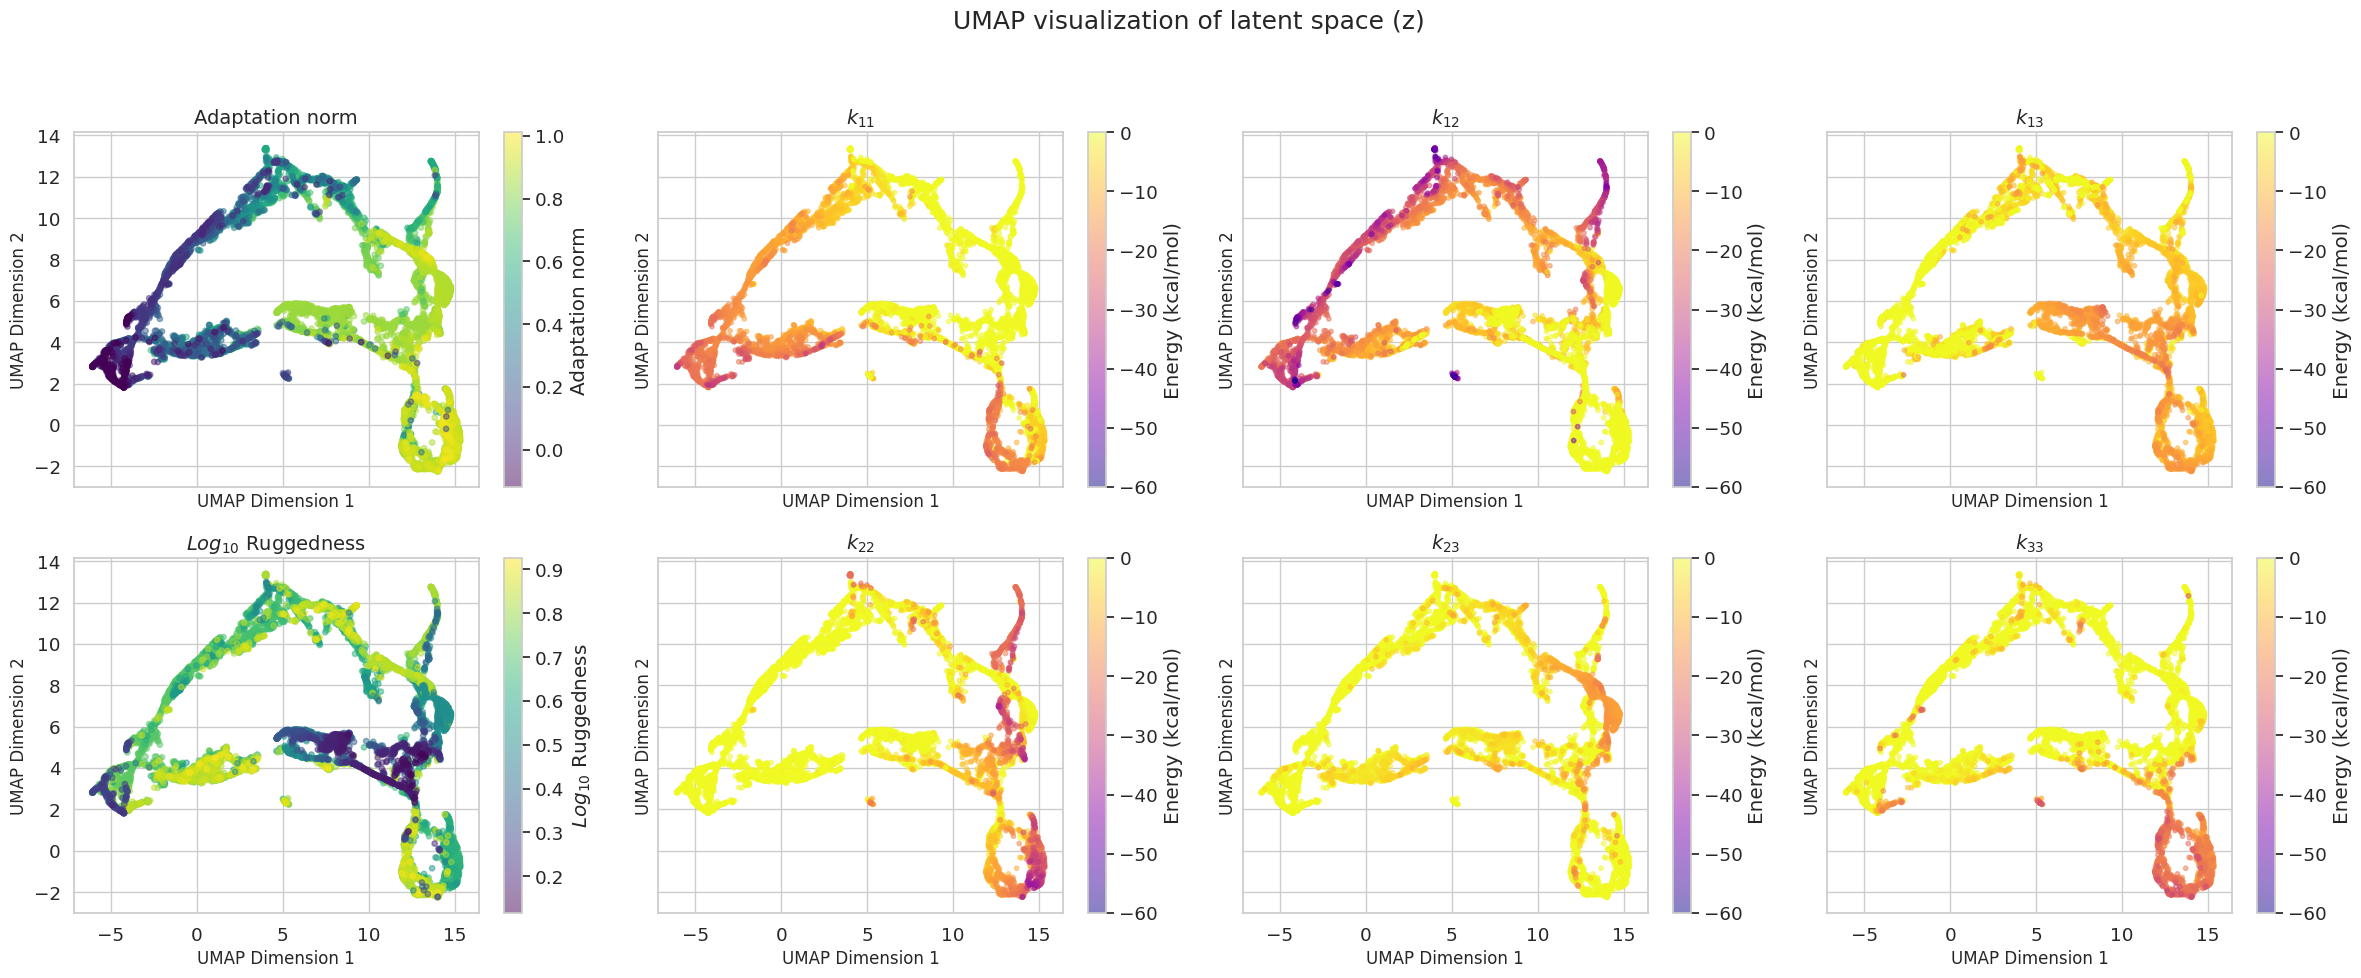

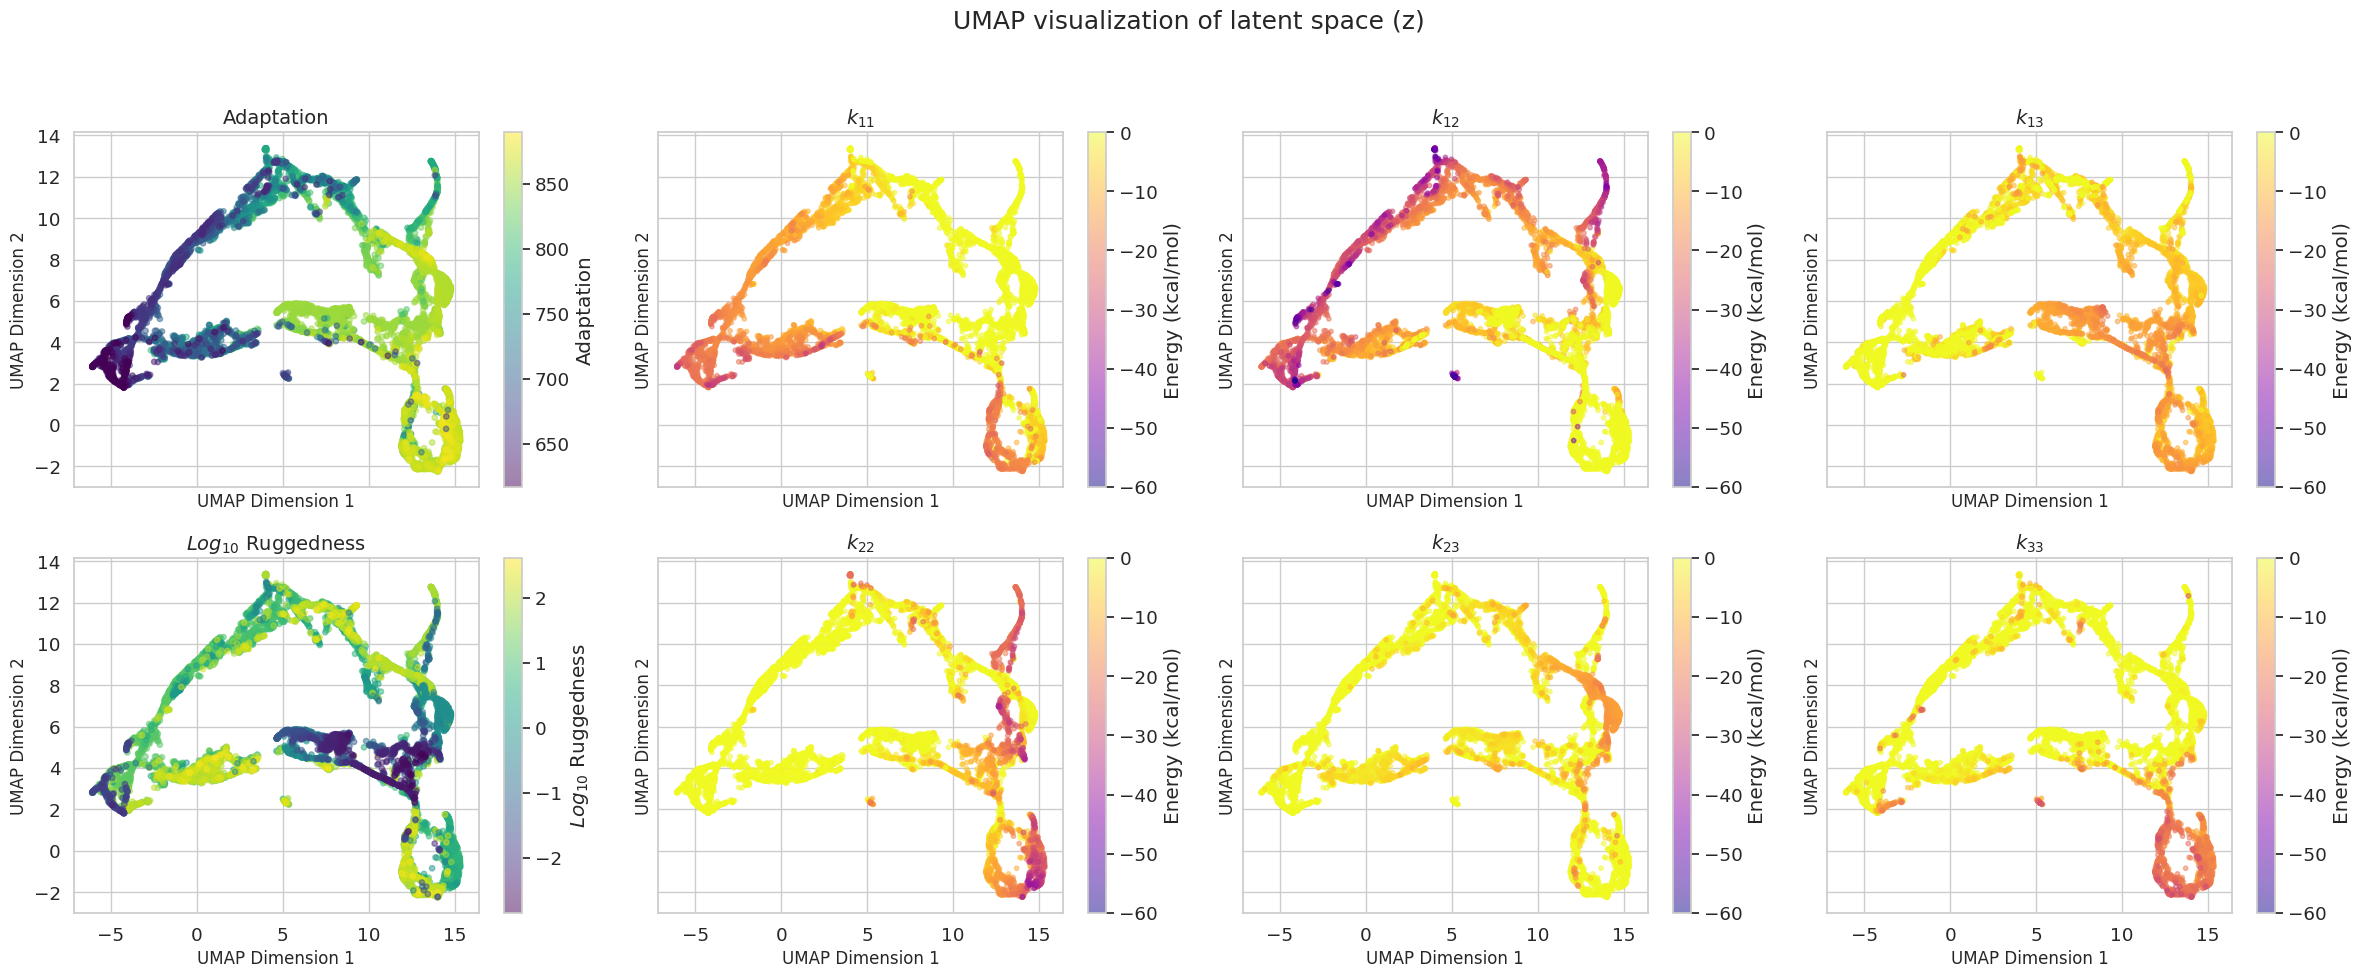

In [19]:
sns.set_style('whitegrid')


def plot_left(fig, axes, dimred_result, labels_cond, cond, s=15):
    
    # Cond plots on the left
    for i, l in enumerate(labels_cond):
        ax_main = fig.add_subplot(axes[i, 0])  # Span both rows
        # idxs_hue = np.argsort(cond[:, i])[::-1]
        # idxs_hue[:len(idxs_hue)//2] = idxs_hue[:len(idxs_hue)//2][::-1]
        idxs_hue = make_sort_hue(
            cond[:, i], sort=True, sort_random=False, sort_flip_prop=4)
        scatter = ax_main.scatter(
            dimred_result[idxs_hue, 0], dimred_result[idxs_hue, 1], c=cond[idxs_hue, i], cmap='viridis', alpha=0.5, s=s)
        ax_main.set_title(
            l.capitalize() if not "ruggedness" in l else r'$Log_{10}$ Ruggedness', fontsize=14)
        ax_main.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax_main.set_ylabel(f'{method} Dimension 2', fontsize=12)
        plt.colorbar(scatter, ax=ax_main, label=l.capitalize()
                     if not "ruggedness" in l else r'$Log_{10}$ Ruggedness')


def visualize_dimred_2d_custom_labels(dimred_result, cond, x_bin, labels_cond, labels_x: list, method='TSNE', save_path=None, use_z=True):
    sns.set_context("notebook", font_scale=1.2)

    ncols = 4 if len(labels_cond) > 1 else (x_bin.shape[-1] + 1)
    nrows = len(labels_cond)
    fig, axes = plt.subplots(nrows, ncols, figsize=(
        6*ncols, 5*nrows), sharex=True, sharey=True)
    if nrows == 1: axes = axes[None, :]

    plot_left(fig, axes, dimred_result, labels_cond, cond)

    # Interaction plots on the right
    for i in range(x_bin.shape[-1]):
        row = i // (ncols-1)
        col = i % (ncols-1) + 1
        ax = fig.add_subplot(axes[row, col])
        # idxs_hue = np.argsort(x_bin[:, i])[::-1]
        # idxs_hue[:len(idxs_hue)//2] = idxs_hue[:len(idxs_hue)//2][::-1]
        idxs_hue = make_sort_hue(
            x_bin[:, i], sort=True, sort_random=False, sort_flip_prop=4)
        scatter = ax.scatter(
            dimred_result[idxs_hue, 0], dimred_result[idxs_hue, 1], c=x_bin[idxs_hue, i], cmap='plasma', alpha=0.5, s=10)
        ax.set_title(labels_x[i], fontsize=14)
        ax.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax.set_ylabel(f'{method} Dimension 2', fontsize=12)
        scatter.set_clim(np.nanmin(x_bin), np.nanmax(x_bin))
        # if i == (x_bin.shape[-1] - 1):
        plt.colorbar(scatter, ax=ax, label=f'Energy (kcal/mol)')

    plt.suptitle(
        f'{method} visualization of latent space ({"z" if use_z else "h"})', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()


def plot_umaps_left(dimred_result, cond, labels_cond, method='TSNE', save_path=None, use_z=True):
    sns.set_context("notebook", font_scale=1.5)

    ncols = 1
    nrows = len(labels_cond)
    fig, axes = plt.subplots(nrows, ncols, figsize=(
        10*ncols, 8*nrows), sharex=True, sharey=True)
    if ncols == 1: axes = axes[:, None]
    if nrows == 1: axes = axes[None, :]
    
    # Cond plots on the left
    plot_left(fig, axes, dimred_result, labels_cond, cond, s=30)

    plt.suptitle(
        f'{method} visualization of latent space ({"z" if use_z else "h"})', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.close()


for norm_setting in ['norm', 'unnorm']:
    if norm_setting == 'norm':

        cond_to_plot = []
        for i, k in enumerate(labels_chosen_a):
            # cond_to_plot.append(y_datanormaliser.create_chain_preprocessor(
            #     y_methods_preprocessing)(cond_rev_all[idxs_show, i], col=k, use_precomputed=True))
            cond_to_plot.append(scale_norm(cond_rev_all[idxs_show, i], key=k, data=data, vmin=0, vmax=1))
        cond_to_plot = np.concatenate([ll[:, None]
                                      for ll in cond_to_plot], axis=-1)

        labels_cond = [f'{l} norm' for l in labels_chosen_a]
    else:
        cond_to_plot = cond_rev_all[idxs_show]
        labels_cond = labels_chosen_a
    visualize_dimred_2d_custom_labels(umap_result, cond_to_plot, all_fake_circuits_flat[idxs_show],
                                      labels_cond=labels_cond,
                                      labels_x=labels_x, method=method, save_path=os.path.join(
                                          top_write_dir, f'umap_full{"_norm" if norm_setting == "norm" else ""}.png'),
                                      use_z=use_z)
    
    plot_umaps_left(umap_result, cond_to_plot, labels_cond=labels_cond, method=method,
                    save_path=os.path.join(
                        top_write_dir, f'umap{"_norm" if norm_setting == "norm" else ""}.png'), use_z=use_z)
    


#### Joint plots of UMAP

In [20]:
# for i, l in enumerate(labels_chosen_a):
#     idxs_hue = make_sort_hue(
#         cond_binned[idxs_show][:, i], sort=True, sort_random=False, sort_flip_prop=4)
#     g = sns.jointplot(
#         x=umap_result[idxs_hue, 0], y=umap_result[idxs_hue, 1], hue=cond_binned[idxs_show][idxs_hue, i], palette='viridis', alpha=0.5, s=10)
#     sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(
#         1.25, 1), title=l.capitalize() if 'ruggedness' not in l else r'$Log_{10}$ Ruggedness')
#     plt.xlabel(f'{method} 1', fontsize=12)
#     plt.ylabel(f'{method} 2', fontsize=12)
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.savefig(os.path.join(
#         top_write_dir, f'umap_joint_{str(i)}.png'), dpi=300, bbox_inches='tight', transparent=True)

# Plot motifs from UMAP


In [21]:
sns.set_context("notebook", font_scale=1.2)

fn_ys = os.path.join(dir_src_rugg, 'ys.npy')
fn_ys_out = os.path.join(dir_src_rugg, 'ys_out.npy')

if os.path.exists(fn_ys):
    ys_out = np.load(fn_ys)[..., idx_output]
    ts = np.load(os.path.join(dir_src_rugg, 'ts.npy'))
elif os.path.exists(fn_ys_out):
    ys_out = np.load(fn_ys_out)
    ts = np.load(os.path.join(dir_src_rugg, 'ts.npy'))

/tmp/ipykernel_2207293/872198936.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High Ruggedness' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  umap_result_df.loc[umap_result_df['UMAP 1'].between(
/tmp/ipykernel_2207293/872198936.py:66: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(umap_result_df[umap_result_df['Selected']], x='UMAP 1',
/tmp/ipykernel_2207293/872198936.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # rect=[0, 0, 1, 0.95])


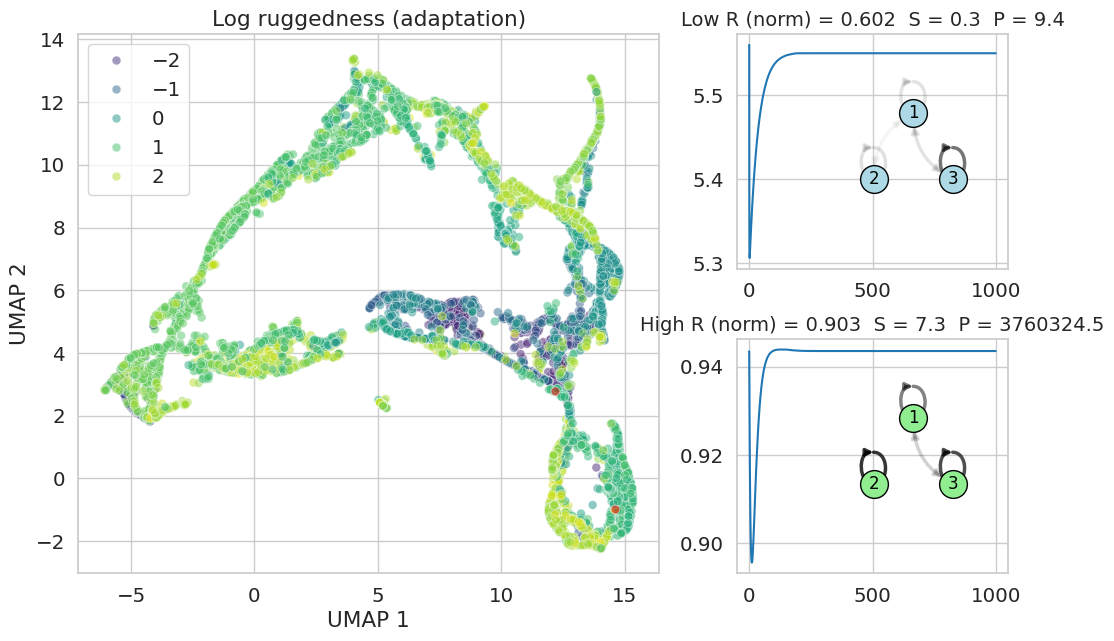

In [101]:
umap_result_df = pd.DataFrame(umap_result, columns=['UMAP 1', 'UMAP 2'])
umap_result_df['Log sensitivity'] = analytics_show['Log sensitivity'][idxs_show, idx_output]
umap_result_df['Log precision'] = analytics_og['Log precision'][idxs_show, idx_output]
umap_result_df['adaptation'] = analytics_show['adaptation'][idxs_show, idx_output]
umap_result_df['overshoot'] = analytics_og['overshoot'][idxs_show, idx_output]
umap_result_df['initial_steady_states'] = analytics_og['initial_steady_states'][idxs_show, idx_output]
umap_result_df['diff_stst_min'] = np.abs(analytics_og['steady_states'] - analytics_og['min_amount'])[idxs_show, idx_output]
umap_result_df['response_time'] = analytics_og['response_time'][idxs_show, idx_output]
umap_result_df['overshoot/initial'] = umap_result_df['overshoot'] / \
    umap_result_df['initial_steady_states']
umap_result_df[k_rugg] = analytics_show[k_rugg][idxs_show, idx_output]
umap_result_df.loc[~np.isfinite(umap_result_df[k_rugg]), k_rugg] = np.nan
umap_result_df[k_rugg_buggy] = analytics_show[k_rugg_buggy][idxs_show, idx_output]
umap_result_df[x_cols] = all_fake_circuits_flat[idxs_show]
umap_result_df['Cluster'] = np.nan
umap_result_df['Selected'] = False
umap_result_df['Is adaptable'] = False
for k in ['adaptation', k_rugg]:
    umap_result_df[f'{k} norm'] = scale_norm(
        umap_result_df[k].values, key=k, data=df, vmin=0, vmax=1)


umap_xy_hirugg = [[10, 16], [-3, 2]]
umap_xy_lorugg = [[5, 15], [2.5, 6]]
# umap_xy_lorugg = [[0, 15], [2.5, 15]]
umap_result_df.loc[umap_result_df['UMAP 1'].between(
    *umap_xy_hirugg[0]) & umap_result_df['UMAP 2'].between(*umap_xy_hirugg[1]), 'Cluster'] = 'High Ruggedness'
umap_result_df.loc[umap_result_df['UMAP 1'].between(
    *umap_xy_lorugg[0]) & umap_result_df['UMAP 2'].between(*umap_xy_lorugg[1]), 'Cluster'] = 'Low Ruggedness'
umap_result_df.loc[((umap_result_df['overshoot/initial'] >= 0.0)
# umap_result_df.loc[((umap_result_df['overshoot'] > 0.1)
                   & (umap_result_df['Log sensitivity'] >= -0.5)
                   & (umap_result_df['Log precision'] > 1)
                #    & (umap_result_df['Log precision'] <= 3)
                #    & (umap_result_df['adaptation'] >= 850)
                #    & (umap_result_df['overshoot/initial'] > 0.1)
                #    & (umap_result_df['steady_states'] > 1)
                #    & (umap_result_df['response_time'] < 1000)
                #    & (umap_result_df['diff_stst_min'] > 1)
                   ), 'Is adaptable'] = True

idxs_adaptable_hirugg = umap_result_df[
    (umap_result_df['Cluster'] == 'High Ruggedness') & (
    umap_result_df['Is adaptable'])
    ].sort_values(by=k_rugg, ascending=False).index[20]
idxs_adaptable_lorugg = umap_result_df[
    (umap_result_df['Cluster'] == 'Low Ruggedness') & (
    # umap_result_df['Is adaptable'])
    umap_result_df[k_rugg + ' norm'].between(0.6, 0.66))
    ].sort_values(by=k_rugg, ascending=True).index[0]
umap_result_df.loc[idxs_adaptable_lorugg, 'Selected'] = True
umap_result_df.loc[idxs_adaptable_hirugg, 'Selected'] = True


fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(2, 3, width_ratios=[6, 1, 1], height_ratios=[
                      1, 1], wspace=0.3, hspace=0.3)

ax_big = fig.add_subplot(gs[:, 0])
ax_top = fig.add_subplot(gs[0, 1:])
ax_bottom = fig.add_subplot(gs[1, 1:])

hue = k_rugg # 'adaptation'
sns.scatterplot(umap_result_df, x='UMAP 1', y='UMAP 2', hue=hue,  # k_rugg, #
                palette='viridis', alpha=0.5, s=40, ax=ax_big)
sns.scatterplot(umap_result_df[umap_result_df['Selected']], x='UMAP 1',
                y='UMAP 2', color='r', palette='viridis', alpha=0.5, s=40, ax=ax_big)
ax_big.set_title(hue)

tmax = 100
idx_perturb_og = -1
ys_p = ys_out.reshape(n_samples, n_perturbs, *ys_out.shape[1:])[:, idx_perturb_og, :tmax]
for ax, c, pos in zip([ax_top, ax_bottom], ['Low Ruggedness', 'High Ruggedness'], [(0.2, 0.1), (0.2, 0.1)]):
    filt = umap_result_df['Selected'] & (umap_result_df['Cluster'] == c)
    w = np.median(umap_result_df[filt][x_cols].values, axis=0)
    sns.lineplot(x=ts[:tmax],
        y=ys_p[idxs_show][umap_result_df[filt].index[0]].flatten(), ax=ax, legend=False)
    create_network_inset(fig, ax, pos=pos, width=0.9, height=0.9, edge_weights=make_nx_weights(w, n_nodes=3, vmin=-30, vmax=0),
                         node_color='lightgreen' if 'High' in c else 'lightblue', linewidth=2.5)
    ax.set_title(c.split('uggedness')[0] + ' (norm) = ' + str(umap_result_df[filt][k_rugg + ' norm'].iloc[0].round(3)) + 
                 '  S = ' + str(np.power(10, umap_result_df[filt]['Log sensitivity'].iloc[0]).round(1)) + 
                 '  P = ' + str(np.power(10, umap_result_df[filt]['Log precision'].iloc[0]).round(1)), fontsize=14)

plt.tight_layout()  # rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'umap_hiloruggs.png'),
            dpi=300, bbox_inches='tight', transparent=True)

High Ruggedness
	Rugg norm	 0.9029797639571278
	adapt		 872.08307
	adapt norm	 0.89706004
	 [-14.84   0.   -10.49 -23.57   0.   -20.78]
Low Ruggedness
	Rugg norm	 0.6021125021925247
	adapt		 871.32544
	adapt norm	 0.8918225
	 [ -3.39  -2.26  -6.39  -3.65   0.   -16.28]


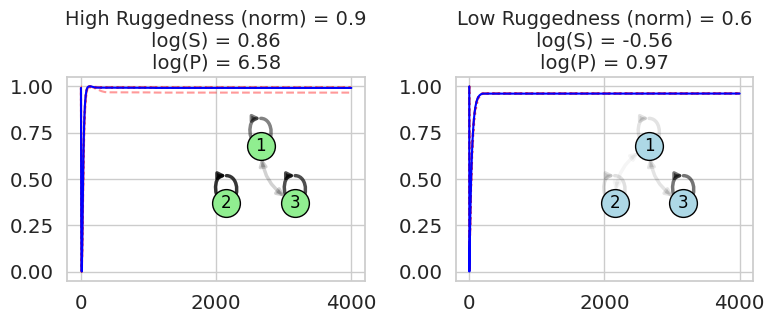

In [97]:
sns.set_context('notebook', font_scale=1.3)
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=False)

for ax, c, pos in zip(axs, ['High Ruggedness', 'Low Ruggedness'], [(0.2, 0.1), (0.2, 0.1)]):

    filt = umap_result_df['Selected'] & (umap_result_df['Cluster'] == c)
    i = idxs_show[umap_result_df[filt].index[0]]
    tmax = ys_out.shape[1]//2
    for crugg in range(n_perturbs):
        ys_p = ys_out.reshape(n_samples, n_perturbs, *ys_out.shape[1:])[i, crugg, :tmax].flatten()
        ys_p = np.interp(ys_p, (ys_p.min(), ys_p.max()), (0, 1))
        ts_p = ts[:tmax]
        is_og = crugg == range(n_perturbs)[idx_perturb_og]
        sns.lineplot(x=ts_p, y=ys_p,
                     ax=ax, 
                     alpha=1 if is_og else 0.4,
                     linestyle=('--' if np.mod(crugg, 2) ==
                                0 else 'dotted') if not(is_og) else '-',
                     color='b' if is_og else 'r')

    w = all_fake_circuits_flat[i]
    create_network_inset(fig, ax, pos=pos, width=0.9, height=0.9, edge_weights=make_nx_weights(w, n_nodes=3, vmin=-30, vmax=0),
                         node_color='lightgreen' if 'High' in c else 'lightblue', linewidth=2.5)
    ax.set_title(
        c + ' (norm) = ' + str(umap_result_df[filt][k_rugg + ' norm'].iloc[0].round(2)) +
        '\nlog(S) = ' + str(umap_result_df[filt]['Log sensitivity'].iloc[0].round(2)) + 
        '\nlog(P) = ' + str(umap_result_df[filt]['Log precision'].iloc[0].round(2)), fontsize=14)

    print(c)
    print('\tRugg norm\t', str(umap_result_df[filt][k_rugg + ' norm'].iloc[0]))
    print('\tadapt\t\t', str(umap_result_df[filt]['adaptation'].iloc[0]))
    print('\tadapt norm\t', str(
        umap_result_df[filt]['adaptation norm'].iloc[0]))
    print('\t', w.round(2))
    np.save(os.path.join(top_write_dir,
            f'circuit_chosen_rugg_{"hi" if "High" in c else "lo"}.npy'), w)

plt.tight_layout()  # rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'umap_hiloruggs_times.png'),
            dpi=300, bbox_inches='tight', transparent=True)

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


((1085, 6), (1499875, 6))

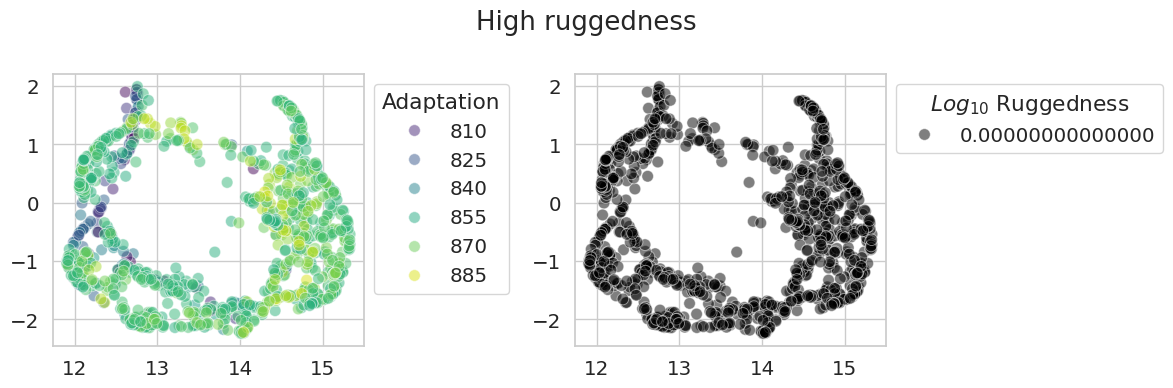

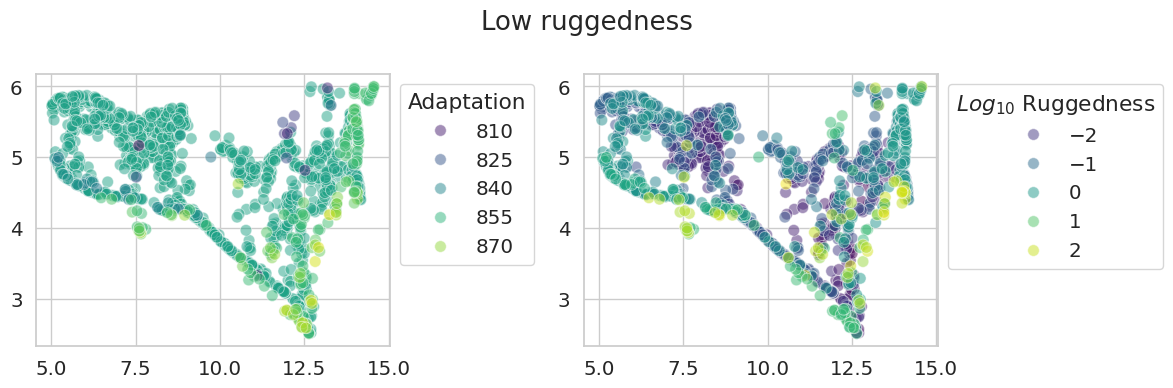

In [33]:
idxs_adaptable_lorugg = np.where((umap_result[:, 0] > umap_xy_lorugg[0][0]) & (umap_result[:, 0] < umap_xy_lorugg[0][1]) &
                                 (umap_result[:, 1] > umap_xy_lorugg[1][0]) & (umap_result[:, 1] < umap_xy_lorugg[1][1]) &
                                 (cond_rev_all[idxs_show][:, 0] > 800))
idxs_adaptable_hirugg = np.where((umap_result[:, 0] > umap_xy_hirugg[0][0]) & (umap_result[:, 0] < umap_xy_hirugg[0][1]) &
                                 (umap_result[:, 1] > umap_xy_hirugg[1][0]) & (umap_result[:, 1] < umap_xy_hirugg[1][1]) &
                                 (cond_rev_all[idxs_show][:, 0] > 800))
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
g = sns.scatterplot(x=umap_result[idxs_adaptable_hirugg, 0].squeeze(), y=umap_result[idxs_adaptable_hirugg, 1].squeeze(
), hue=cond_rev_all[idxs_show][idxs_adaptable_hirugg, 0].squeeze(), palette='viridis', alpha=0.5, s=70, ax=axs[0])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Adaptation')
g = sns.scatterplot(x=umap_result[idxs_adaptable_hirugg, 0].squeeze(), y=umap_result[idxs_adaptable_hirugg, 1].squeeze(
), hue=cond_rev_all[idxs_show][idxs_adaptable_hirugg, 1].squeeze(), palette='viridis', alpha=0.5, s=70, ax=axs[1])
sns.move_legend(g, "upper left", bbox_to_anchor=(
    1, 1), title=r'$Log_{10}$ Ruggedness')
plt.suptitle('High ruggedness')
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
g = sns.scatterplot(x=umap_result[idxs_adaptable_lorugg, 0].squeeze(), y=umap_result[idxs_adaptable_lorugg, 1].squeeze(
), hue=cond_rev_all[idxs_show][idxs_adaptable_lorugg, 0].squeeze(), palette='viridis', alpha=0.5, s=70, ax=axs[0])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Adaptation')
g = sns.scatterplot(x=umap_result[idxs_adaptable_lorugg, 0].squeeze(), y=umap_result[idxs_adaptable_lorugg, 1].squeeze(
), hue=cond_rev_all[idxs_show][idxs_adaptable_lorugg, 1].squeeze(), palette='viridis', alpha=0.5, s=70, ax=axs[1])
sns.move_legend(g, "upper left", bbox_to_anchor=(
    1, 1), title=r'$Log_{10}$ Ruggedness')
plt.suptitle('Low ruggedness')
plt.tight_layout()

all_fake_circuits_flat[idxs_show][idxs_adaptable_hirugg].shape, all_fake_circuits_flat.shape

In [34]:
cols_e = [r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i))
                                                                   for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))]

### Low ruggedness adaptable circuits clusters


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


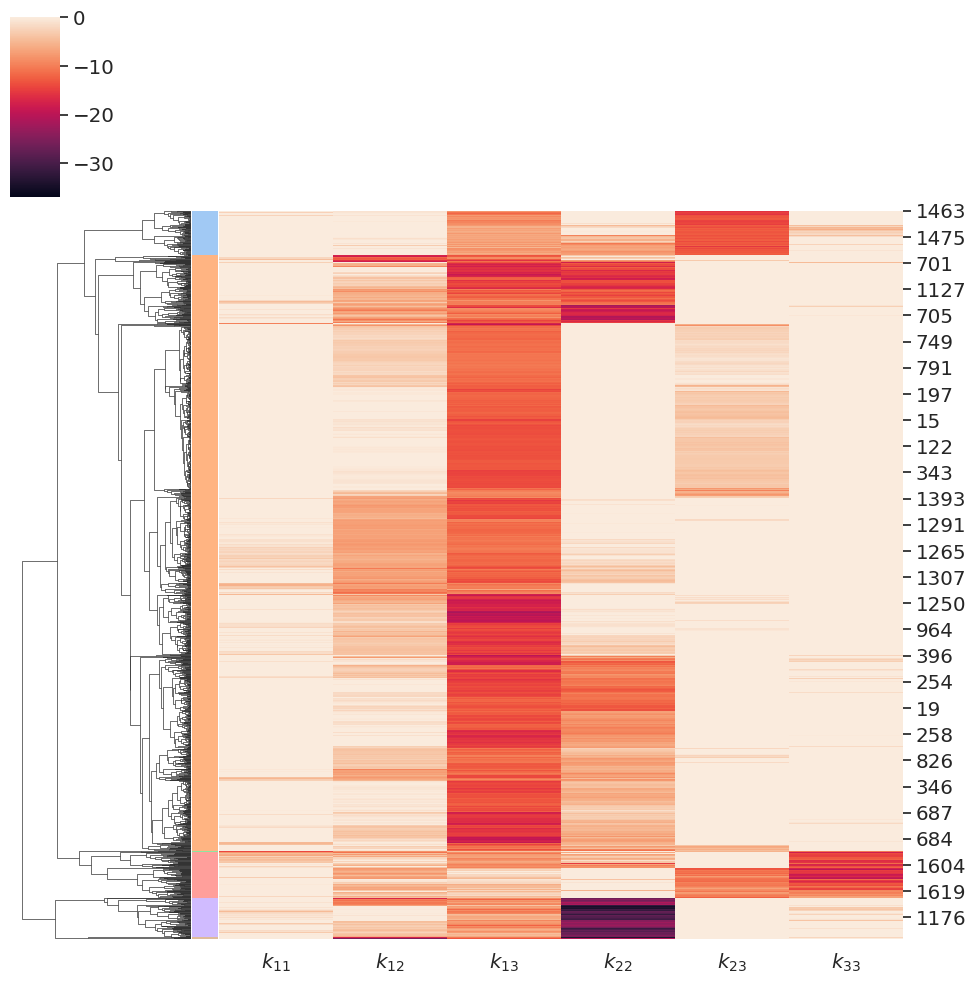

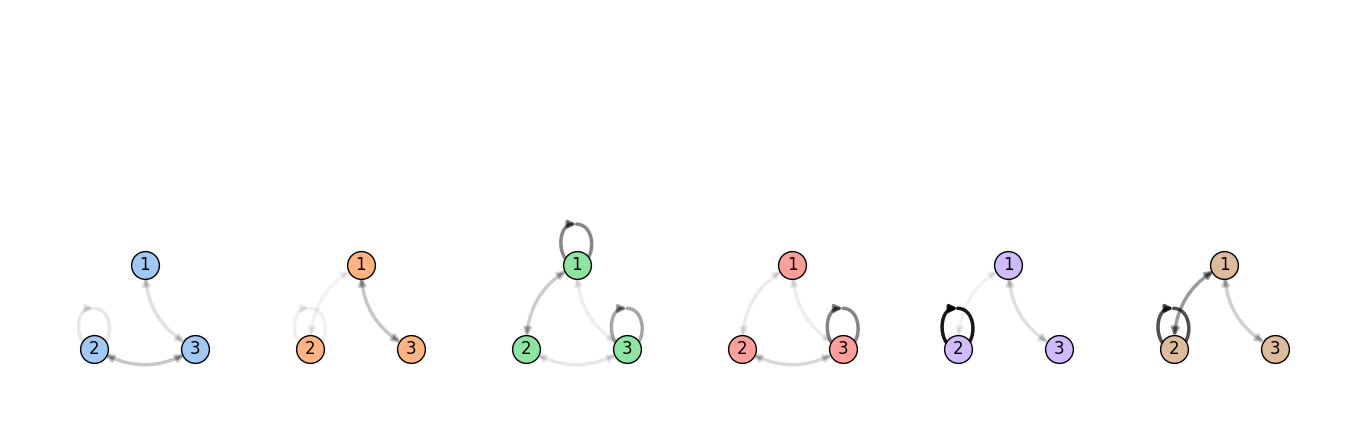

In [35]:
def plot_cluster(row_colors, idxs):
    g = sns.clustermap(pd.DataFrame(all_fake_circuits_flat[idxs_show][idxs], columns=cols_e), col_cluster=False, row_colors=row_colors
                       )
    n_clusters = 6
    row_linkage = g.dendrogram_row.linkage
    clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')

    if row_colors is None:
        plt.close()
        del g

    lut = dict(zip(sorted(pd.Series(clusters).unique()),
                   sns.color_palette('pastel', n_clusters).as_hex()))
    row_colors = pd.Series(clusters).map(lut).to_numpy()

    return row_colors, clusters, n_clusters


row_colors = None
row_colors, clusters, n_clusters = plot_cluster(
    row_colors, idxs_adaptable_lorugg)
row_colors, clusters, n_clusters = plot_cluster(
    row_colors, idxs_adaptable_lorugg)

fig, ax = plt.subplots(figsize=(15, 5))
d_lo = pd.DataFrame()
# cols_e = sorted(set([hpos['x_type'] + '_' + '-'.join(sorted([str(i + 1), str(j + 1)]))
#                 for i, j in itertools.product(range(3), range(3))]))
d_lo['Cluster'] = clusters
d_lo[cols_e] = all_fake_circuits_flat[idxs_show][idxs_adaptable_lorugg]
for i, c in enumerate(labels_chosen_a):
    d_lo[c] = cond_rev_all[idxs_show][idxs_adaptable_lorugg, i].squeeze()
pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.3,
                     np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
colors = sns.color_palette('pastel', n_clusters).as_hex()
d_lo = d_lo[d_lo['Cluster'].apply(
    lambda x: np.where(clusters == x, 1, 0).sum() > 2)]
for i, c in enumerate(sorted(d_lo['Cluster'].unique())):
    fake_circuits_cluster = d_lo[d_lo['Cluster']
                                 == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             # np.nanmin(all_fake_circuits_flat[idxs_show]),
                                                                             vmin=-30,
                                                                             vmax=0),  # np.nanmax(all_fake_circuits_flat[idxs_show]),),
                         node_color=colors[c-1], linewidth=2.5)
ax.set_axis_off()
plt.savefig(os.path.join(top_write_dir, 'motifs_adapt_lorugg.png'),
            dpi=300, bbox_inches='tight', transparent=True)

In [36]:
d_lo.groupby('Cluster')[labels_chosen_a].agg(['min', 'mean', 'std', 'count']).T

Cluster                                     1            2           3  \
adaptation                  min    856.276306   811.802979  803.269653   
                            mean   857.741333   848.767212  811.290222   
                            std      1.401606     2.633893    9.780834   
                            count  103.000000  1365.000000    3.000000   
Log ruggedness (adaptation) min     -0.714069    -2.851460    1.921466   
                            mean    -0.061460    -1.454476    2.119835   
                            std      0.086209     0.882423    0.283681   
                            count  103.000000  1365.000000    3.000000   

Cluster                                     4           5           6  
adaptation                  min    856.328430  845.768127  812.358521  
                            mean   863.547424  848.946533  829.187805  
                            std      6.377947    0.559856   16.234922  
                            count  104.000000   91.000000    3.000000  
Log ruggedness (adaptation) min      0.235436   -2.283602   -0.320924  
                            mean     1.334316   -0.761695    1.050894  
                            std      0.595676    0.597865    1.201352  
                            count  104.000000   91.000000    3.000000

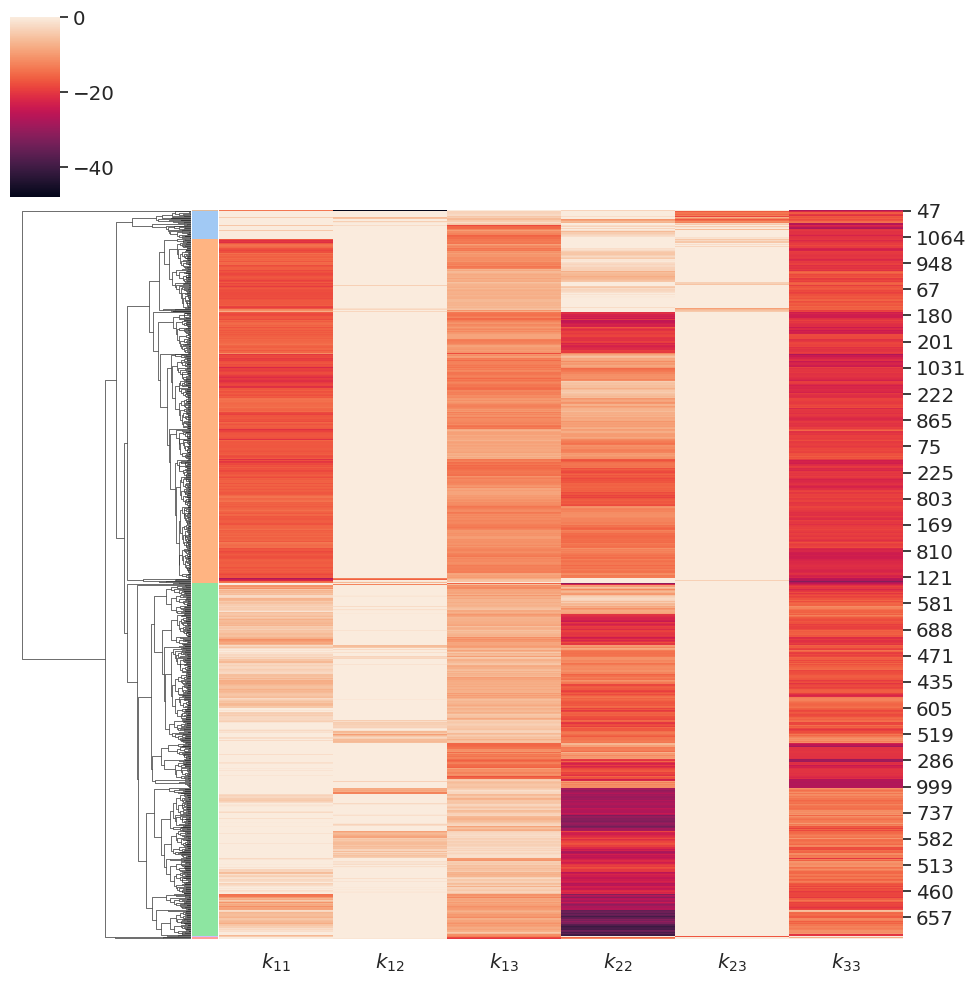

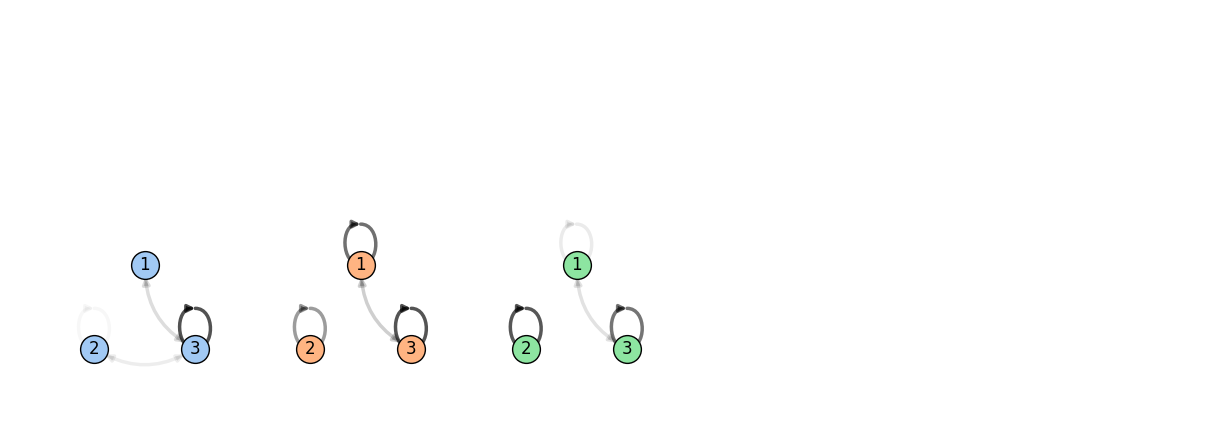

In [37]:
row_colors = None
row_colors, clusters, n_clusters = plot_cluster(
    row_colors, idxs_adaptable_hirugg)
row_colors, clusters, n_clusters = plot_cluster(
    row_colors, idxs_adaptable_hirugg)


fig, ax = plt.subplots(figsize=(15, 5))
d_hi = pd.DataFrame()
# cols_e = sorted(set([hpos['x_type'] + '_' + '-'.join(sorted([str(i + 1), str(j + 1)]))
#                 for i, j in itertools.product(range(3), range(3))]))
d_hi['Cluster'] = clusters
d_hi[cols_e] = all_fake_circuits_flat[idxs_show][idxs_adaptable_hirugg]
for i, c in enumerate(labels_chosen_a):
    d_hi[c] = cond_rev_all[idxs_show][idxs_adaptable_hirugg, i].squeeze()
pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.3,
                     np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
colors = sns.color_palette('pastel', n_clusters).as_hex()
d_hi = d_hi[d_hi['Cluster'].apply(
    lambda x: np.where(clusters == x, 1, 0).sum() > 2)]
for i, c in enumerate(sorted(d_hi['Cluster'].unique())):
    fake_circuits_cluster = d_hi[d_hi['Cluster']
                                 == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             # np.nanmin(all_fake_circuits_flat[idxs_show]),
                                                                             vmin=-30,
                                                                             vmax=0),  # np.nanmax(all_fake_circuits_flat[idxs_show]),),
                         node_color=colors[c-1], linewidth=2.5)
ax.set_axis_off()
plt.savefig(os.path.join(top_write_dir, 'motifs_adapt_hirugg.png'),
            dpi=300, bbox_inches='tight', transparent=True)

In [38]:
d_hi.groupby('Cluster')[labels_chosen_a].agg(['mean', 'std', 'count']).T

Cluster                                     1           2           3
adaptation                  mean   867.291321  851.678772  865.449341
                            std      9.346476   17.870903    7.703261
                            count   41.000000  513.000000  527.000000
Log ruggedness (adaptation) mean     0.825524        -inf    0.662269
                            std      1.235016         NaN    0.468834
                            count   41.000000  513.000000  527.000000

# Specific circuits


In [39]:
# df_plot = pd.DataFrame()
# df_plot['UMAP 1'] = umap_result[:, 0]
# df_plot['UMAP 2'] = umap_result[:, 1]
# for i, l in enumerate(labels_chosen_a):
#     df_plot[l] = cond_binned[idxs_show][:, i]

### High adaptation, low ruggedness


In [40]:
df_rugg['Is adaptable'] = False
df_rugg['Is adaptable og'] = False
df_rugg.loc[(df_rugg['Log sensitivity'] > 0) & (df_rugg['Log precision'] > 1),
            'Is adaptable og'] = True  # np.nanmax(df_rugg['Adaptation bin']) + 20
df_rugg.loc[df_rugg['adaptation'] > 870, 'Is adaptable'] = True

data['Is adaptable'] = False
data['Is adaptable og'] = False
data.loc[(data['Log sensitivity'] > 0) & (data['Log precision'] > 1),
         'Is adaptable og'] = True  # np.nanmax(data['Adaptation bin']) + 20
# np.nanmax(data['Adaptation bin']) + 20
data.loc[data['adaptation'] > 870, 'Is adaptable'] = True

### Adaptable high + low motifs from all data, not just UMAP


In [41]:
# filt_adaptable = df_rugg['Is adaptable']
filt_adaptable = (df_rugg['Log sensitivity'] >= 0) & (
    df_rugg['Log precision'] >= 1) # & (df_rugg['overshoot/initial'] > 0.01)
idxs_adaptable = df_rugg[filt_adaptable].index.to_list()
filt_adaptable_lorugg = filt_adaptable & (
    df_rugg['Log ruggedness (adaptation)'] <= 1.2)
filt_adaptable_hirugg = filt_adaptable & (
    df_rugg['Log ruggedness (adaptation)'] > 1.2)
idxs_adaptable_lorugg2 = df_rugg[filt_adaptable_lorugg].index.to_list()
idxs_adaptable_hirugg2 = df_rugg[filt_adaptable_hirugg].index.to_list()

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_2207293/681646515.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.violinplot(data=df_plot, x='Cluster',
/tmp/ipykernel_2207293/681646515.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


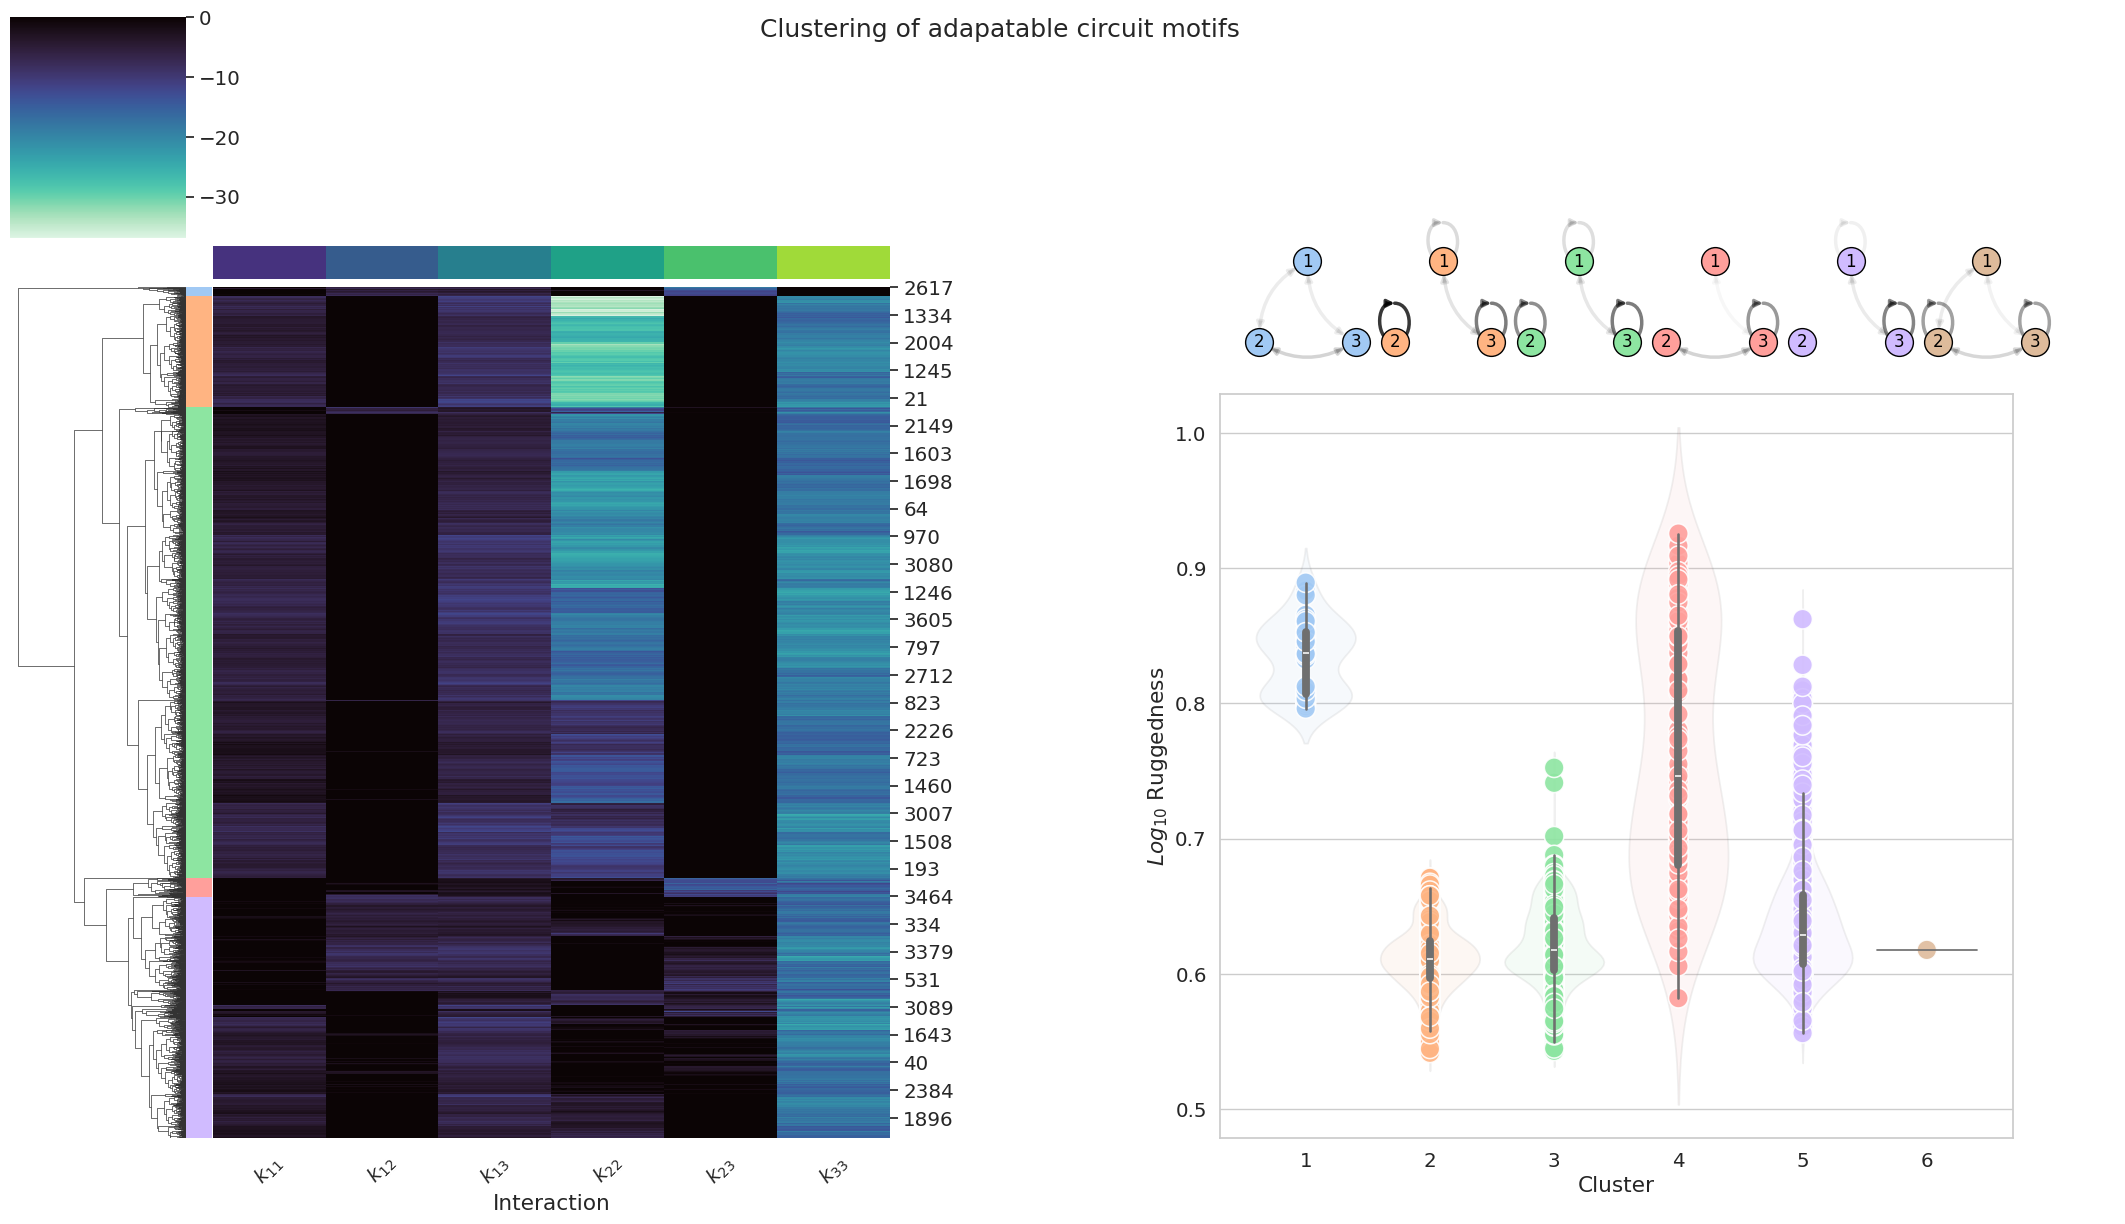

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_2207293/681646515.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.violinplot(data=df_plot, x='Cluster',
/tmp/ipykernel_2207293/681646515.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


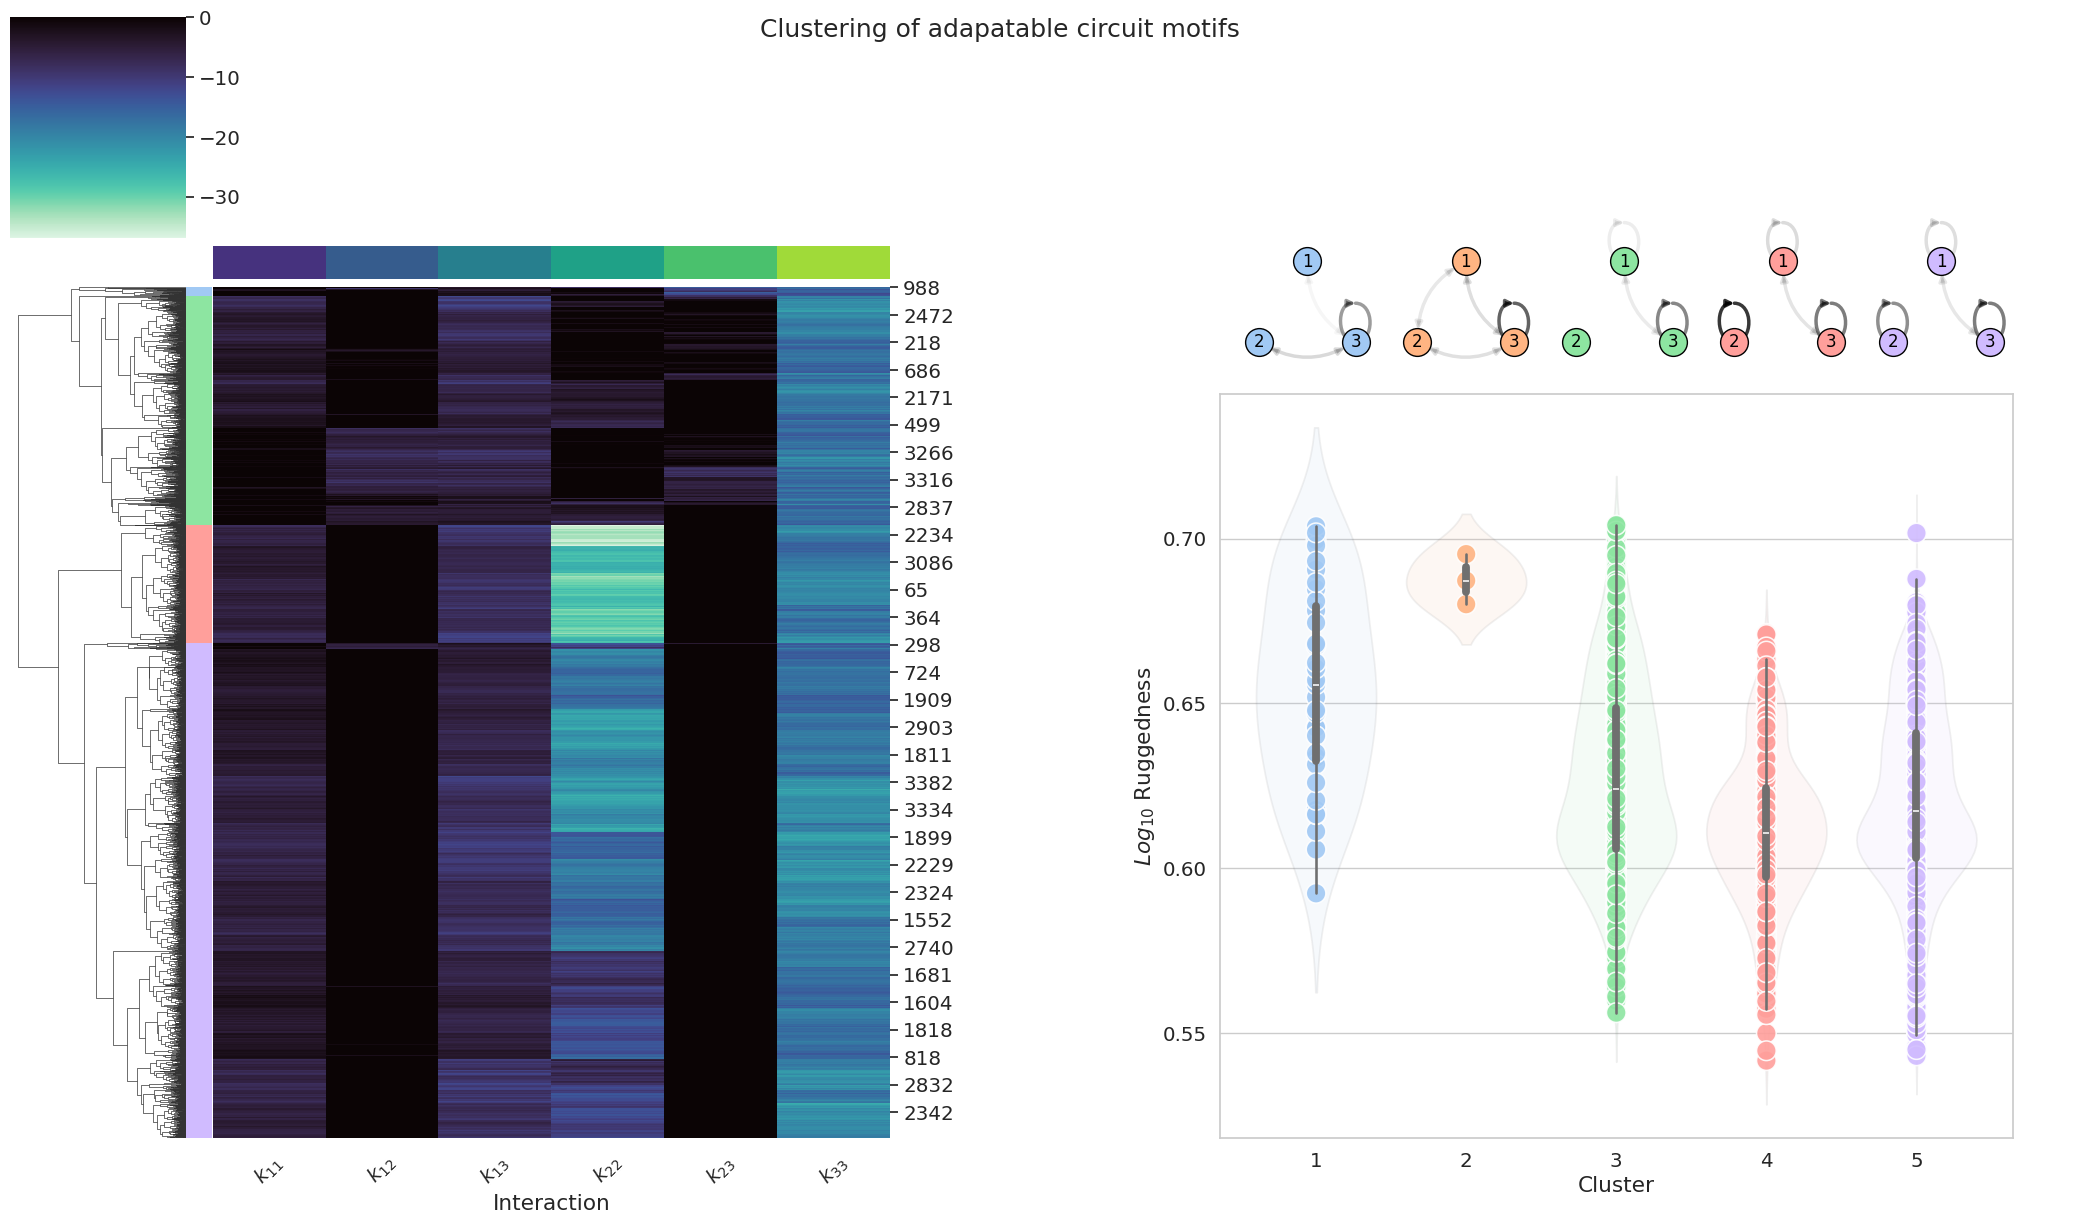

/tmp/ipykernel_2207293/681646515.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.violinplot(data=df_plot, x='Cluster',
/tmp/ipykernel_2207293/681646515.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


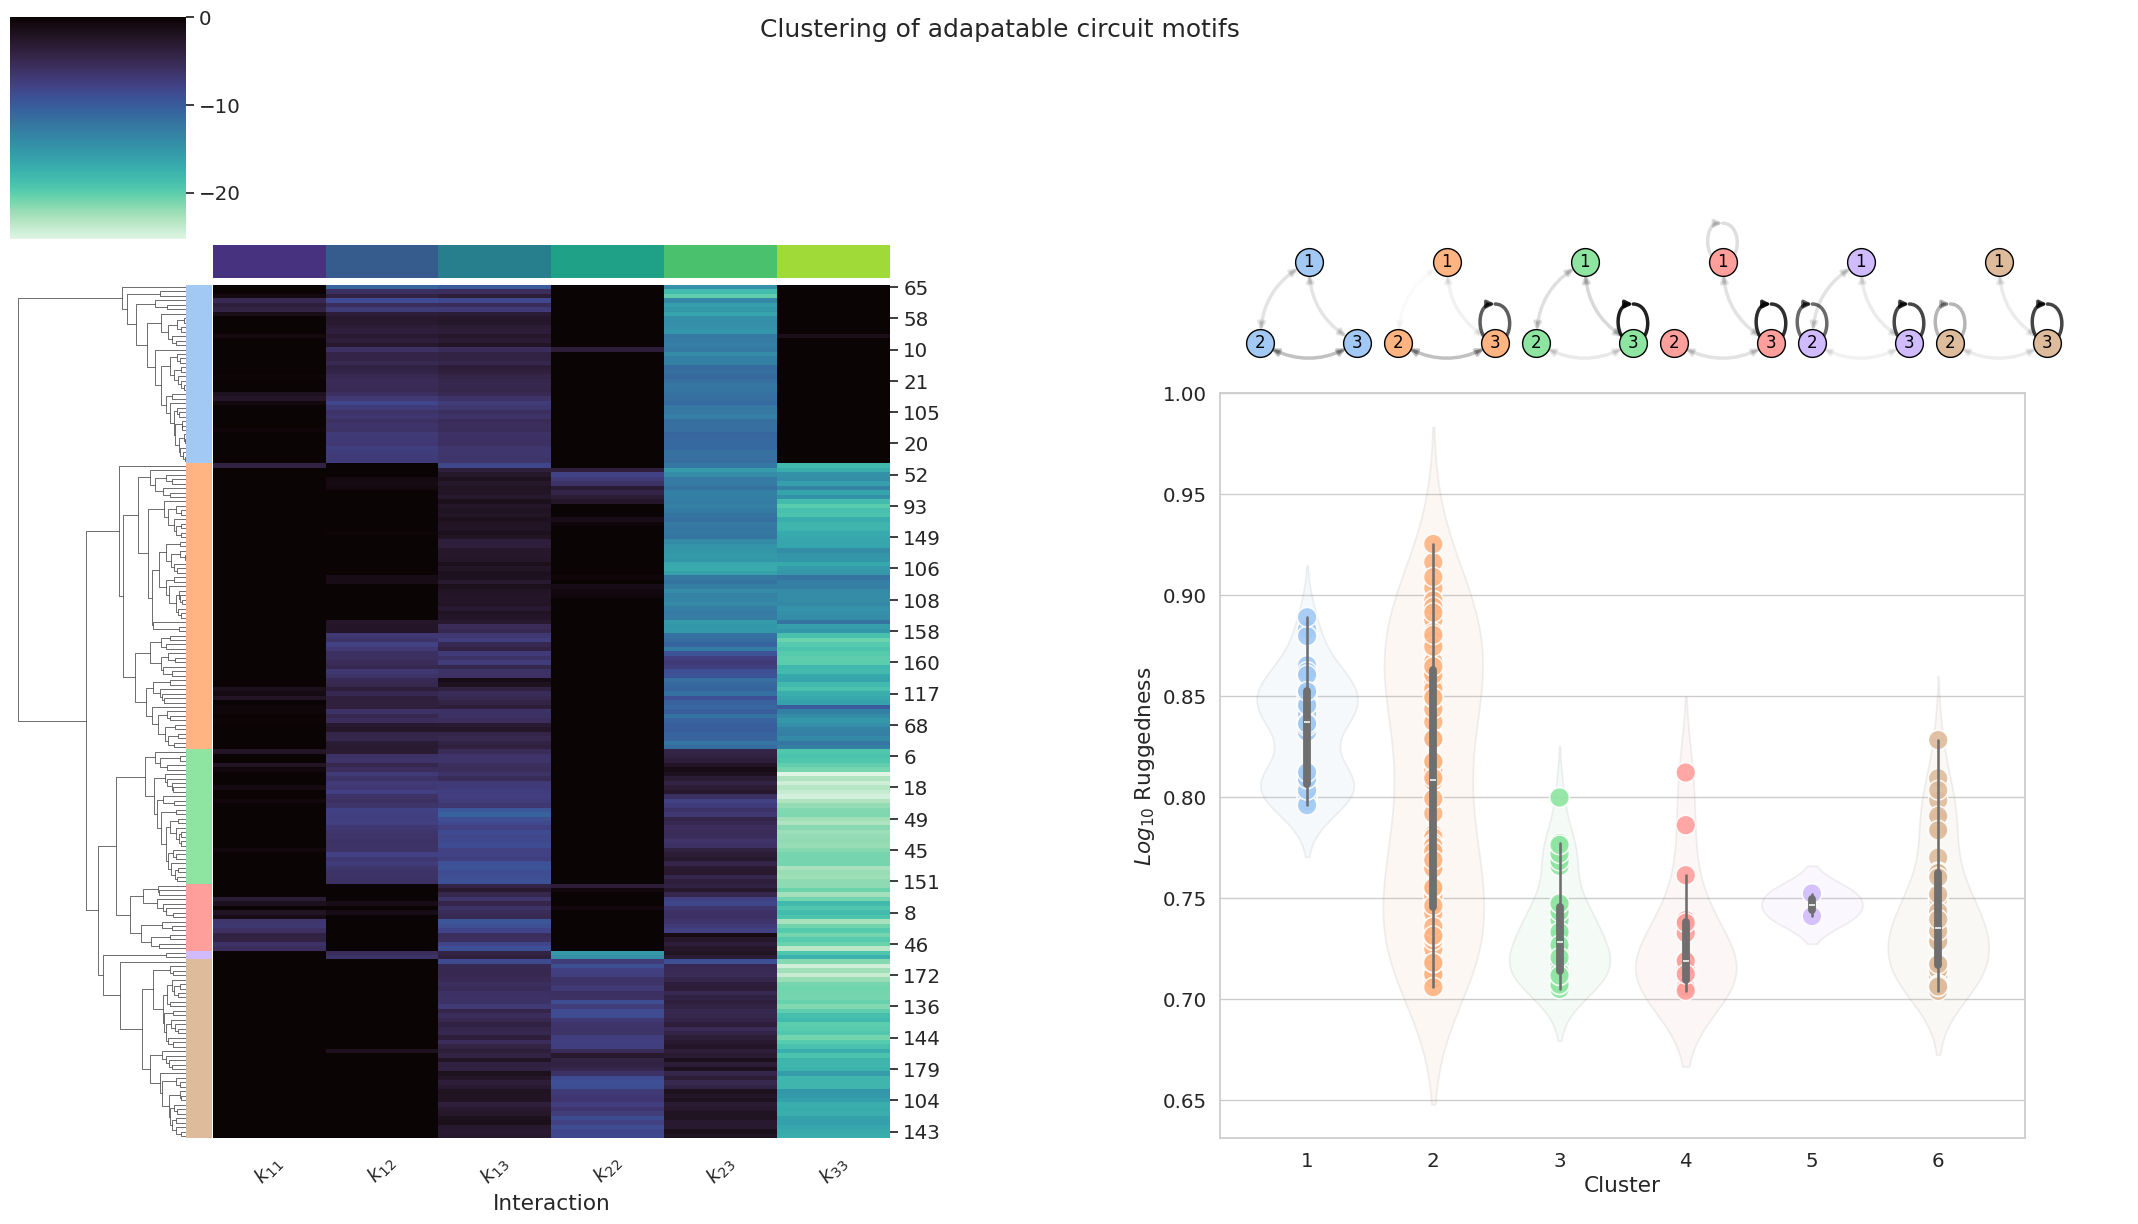

In [42]:
def plot_clusters(idxs, df_filt, save_name, n_clusters=5):
    g = sns.clustermap(all_fake_circuits_flat[idxs], col_cluster=False)
    row_linkage = g.dendrogram_row.linkage
    clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
    df_plot = pd.DataFrame()
    df_plot['Cluster'] = clusters
    df_plot[cols_e] = all_fake_circuits_flat[idxs]
    for k in ['Log ruggedness (adaptation)', 'Adaptation', 'Prompt Adaptation', 'Prompt Ruggedness', 'Prompt Ruggedness Unnorm', 'Log ruggedness (adaptation) norm']:
        if k in df_filt.columns:
            df_plot[k] = df_filt[k].values
    lut = dict(zip(sorted(df_plot['Cluster'].unique()),
                   sns.color_palette('pastel', n_clusters).as_hex()))
    row_colors = df_plot['Cluster'].map(lut).to_numpy()
    col_colors = sns.color_palette(
        'viridis', all_fake_circuits_flat.shape[-1]).as_hex()

    plt.close()
    del g


    figsize = (22, 12)
    g = sns.clustermap(all_fake_circuits_flat[idxs], col_cluster=False,
                       col_colors=sns.color_palette(
        "viridis", all_fake_circuits_flat.shape[-1]),
        row_colors=row_colors, figsize=figsize,
        cmap='mako_r')
    g.ax_heatmap.set_xlabel('Interaction')
    g.ax_heatmap.set_xticklabels(cols_e, rotation=45)
    g.gs.update(left=0.05, right=0.45)

    gs2 = matplotlib.gridspec.GridSpec(3, 1, left=0.6)
    ax2 = g.figure.add_subplot(gs2[0])
    ax3 = g.figure.add_subplot(gs2[1:])

    g2 = sns.violinplot(data=df_plot, x='Cluster',
                        y='Log ruggedness (adaptation) norm', ax=ax3, palette='pastel', alpha=0.1)
    df_plot['Cluster 0'] = df_plot['Cluster'] - 1
    g2 = sns.scatterplot(data=df_plot, x='Cluster 0', y='Log ruggedness (adaptation) norm', hue='Cluster', ax=ax3, palette='pastel',
                         s=200, alpha=0.9, legend=False)
    ax3.set_ylabel(r'$Log_{10}$ Ruggedness')

    ax2.set_axis_off()
    pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.2,
                          np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
    colors = sns.color_palette('pastel', n_clusters).as_hex()
    for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
        fake_circuits_cluster = df_plot[df_plot['Cluster']
                                        == c][cols_e].values
        w = np.median(fake_circuits_cluster, axis=0)
        create_network_inset(fig, ax2,
                             pos=pos[i],
                             width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                                 vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                             node_color=colors[i], linewidth=2.5)

    plt.suptitle('Clustering of adapatable circuit motifs', fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(
        top_write_dir, save_name + '.png'), dpi=300, transparent=True)

    plt.show()

    return df_plot


n_clusters = 6
df_plot = plot_clusters(
    idxs_adaptable, df_rugg[filt_adaptable], 'interaction_energy_clusters', n_clusters)
df_plot_lo = plot_clusters(
    idxs_adaptable_lorugg2, df_rugg[filt_adaptable_lorugg], 'interaction_energy_clusters_lo', n_clusters=5)
df_plot_hi = plot_clusters(
    idxs_adaptable_hirugg2, df_rugg[filt_adaptable_hirugg], 'interaction_energy_clusters_hi', n_clusters=6)

/tmp/ipykernel_2207293/3866600426.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.violinplot(data=df_plot[filt_c], x='Cluster', y='Log ruggedness (adaptation)',


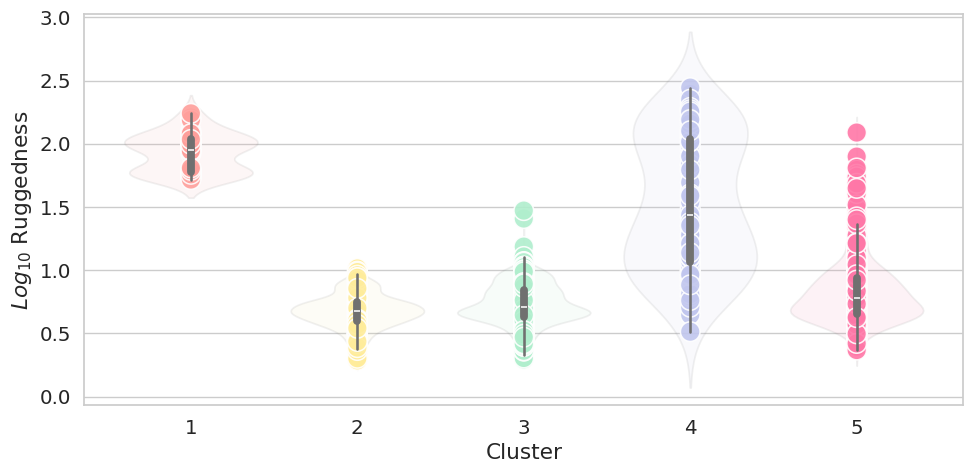

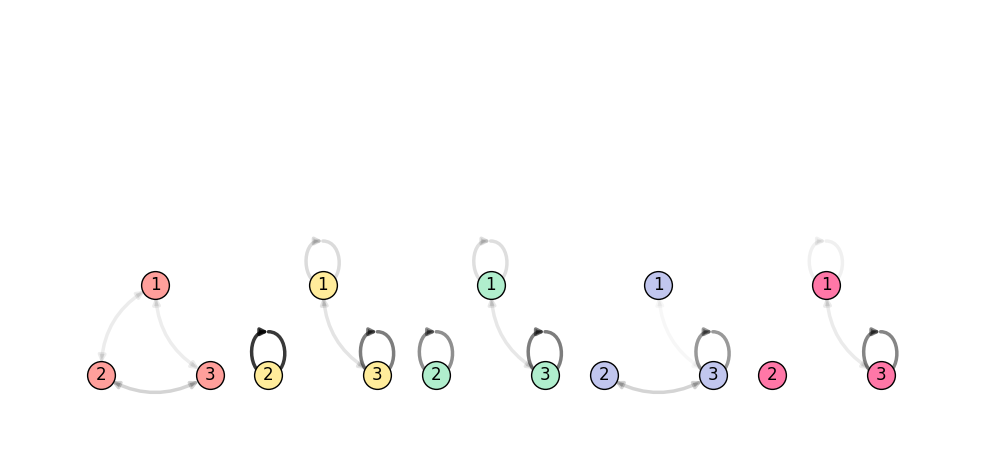

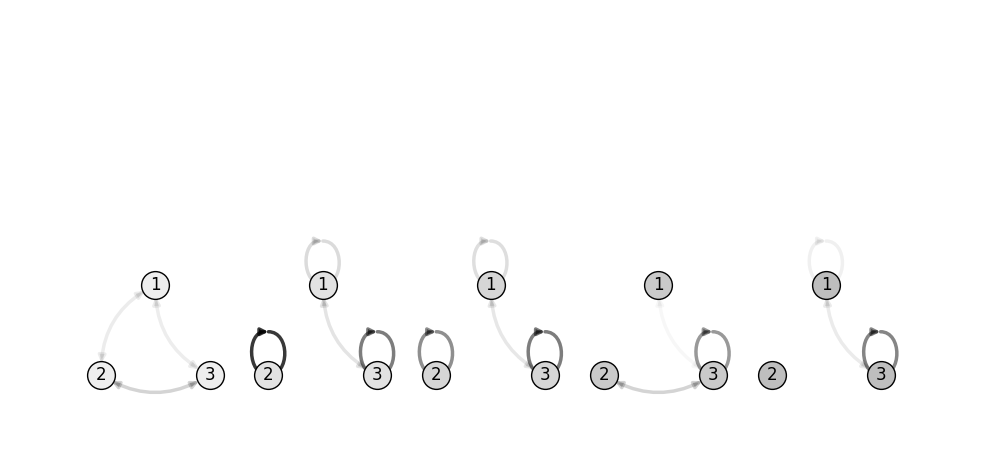

In [43]:
exclude_clusters = [6]
filt_c = ~df_plot['Cluster'].isin(exclude_clusters)
n_clusters = df_plot[filt_c]['Cluster'].nunique()
custom_palette = sns.blend_palette(
    ['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=n_clusters)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
ax = axs
g = sns.violinplot(data=df_plot[filt_c], x='Cluster', y='Log ruggedness (adaptation)',
                   ax=ax, palette=custom_palette, alpha=0.1)
g = sns.scatterplot(data=df_plot[filt_c], x='Cluster 0', y='Log ruggedness (adaptation)', hue='Cluster', ax=ax, palette=custom_palette,
                    s=200, alpha=0.9, legend=False)
ax.set_ylabel(r'$Log_{10}$ Ruggedness')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'interaction_energy_clusters_horiz1.png'), dpi=300, transparent=True)


# custom_palette2 = sns.blend_palette(["#ffc7a7", "#ff9b9b", "#fc759e", "#f374f5", "#b560fa"], n_colors=n_clusters)
custom_palette2 = sns.blend_palette(
    ["#eeeeee", "#BEBEBE"], n_colors=n_clusters)
for orientation in ['vertical', 'horizontal']:
    for ii, palette in enumerate([custom_palette, custom_palette2]):
        nrows = 1 if orientation == 'horizontal' else 2
        ncols = 1 if orientation == 'vertical' else 2
        fig, axs = plt.subplots(1, 1, figsize=(
            5*ncols, (5 + (2.5 if orientation == 'vertical' else 0))*nrows))
        ax = axs
        ax.set_axis_off()
        pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.2,
                              np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
        if orientation == 'vertical':
            pos = np.flipud(np.roll(pos, shift=1, axis=1))
        colors = sns.color_palette(palette, n_clusters).as_hex()
        for i, c in enumerate(sorted(df_plot[filt_c]['Cluster'].unique())):
            fake_circuits_cluster = df_plot[filt_c][df_plot[filt_c]['Cluster']
                                            == c][cols_e].values
            w = np.median(fake_circuits_cluster, axis=0)
            create_network_inset(fig, ax, pos=pos[i],
                                 width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                                     vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                                 node_color=colors[i], linewidth=2.5)
        plt.tight_layout()
        plt.savefig(os.path.join(
            top_write_dir, f'motifs_adapt{ii}_{orientation[:3]}.png'), dpi=300, transparent=True)

        if orientation == 'vertical':
            plt.close()

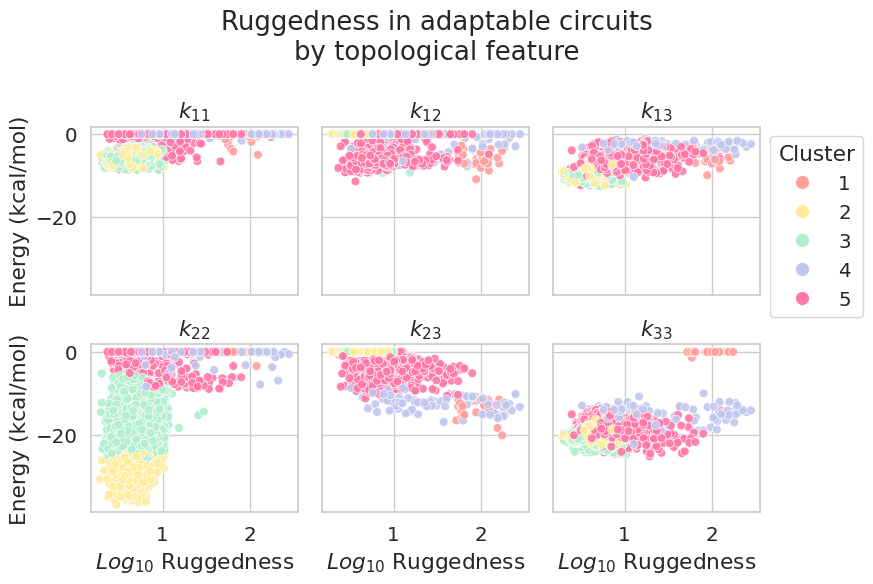

In [44]:
fig, axs = plt.subplots(2, 3, figsize=(3*3, 3*2), sharex=True, sharey=True)
# df_plot = df_plot.iloc[np.random.choice(np.arange(len(df_plot)), len(df_plot))]
for i, c in enumerate(cols_e):

    is_legend = True if i == 2 else False
    g = sns.scatterplot(df_plot[filt_c],
                        x='Log ruggedness (adaptation)', y=c, hue='Cluster', alpha=0.9, s=40,
                        ax=axs.flat[i], palette=custom_palette, legend=is_legend)
    axs.flat[i].set_xlabel(r'$Log_{10}$ Ruggedness')
    axs.flat[i].set_ylabel('Energy (kcal/mol)')
    axs.flat[i].set_title(labels_x[i])

    if is_legend:
        for line in g.legend().get_lines():
            line.set(alpha=1.0, markersize=10)
        sns.move_legend(g, "upper left", bbox_to_anchor=(
            1, 1), title='Cluster')

plt.suptitle('Ruggedness in adaptable circuits\nby topological feature')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'ruggedness_by_interaction_energy.png'), dpi=300, transparent=True)

/tmp/ipykernel_2207293/853757783.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


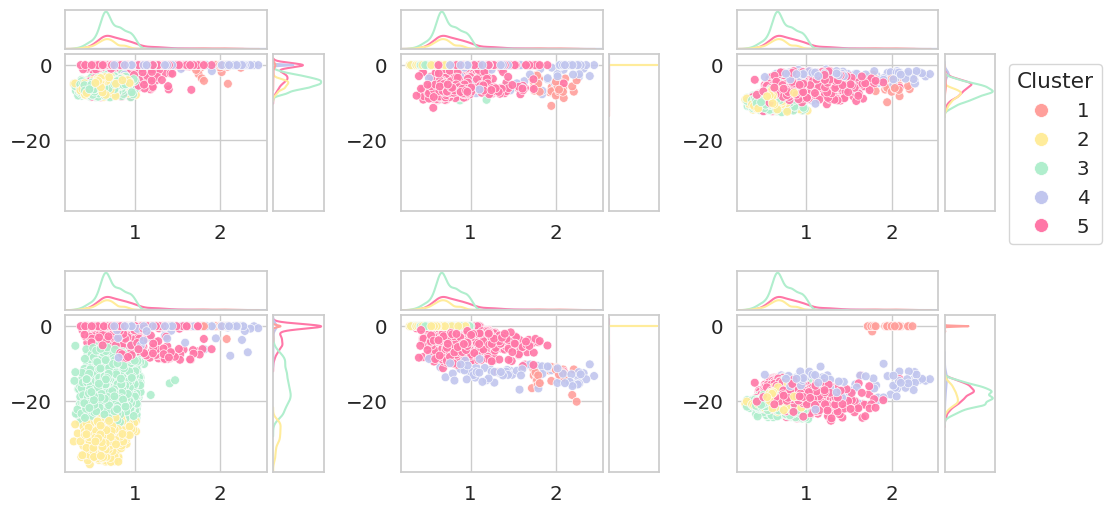

In [45]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
outer = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.3)
x_label = 'Log ruggedness (adaptation)'
xlim = (df_plot[filt_c][x_label].min() - 0.1, df_plot[filt_c][x_label].max() + 0.1)
ylim = (df_plot[filt_c][cols_e].min().min() - 2, df_plot[filt_c][cols_e].max().max() + 3)

for i, c in enumerate(cols_e):
    is_legend = True if i == 2 else False

    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                                             subplot_spec=outer[i],
                                             width_ratios=[4, 1],
                                             height_ratios=[1, 4],
                                             wspace=0.05, hspace=0.05)

    # Histogram (top)
    ax_xhist = plt.Subplot(fig, inner[0, 0])
    sns.kdeplot(df_plot[filt_c],
                x=x_label,
                hue='Cluster', palette=custom_palette,
                ax=ax_xhist, legend=False)
    ax_xhist.set_xlim(xlim)
    ax_xhist.set_xticks([])
    ax_xhist.set_yticks([])
    ax_xhist.set_xlabel('')
    ax_xhist.set_ylabel('')
    # ax_xhist.set_title(labels_x[i])
    fig.add_subplot(ax_xhist)

    # Right y-histogram
    ax_yhist = plt.Subplot(fig, inner[1, 1])
    sns.kdeplot(df_plot[filt_c],
                y=c,
                hue='Cluster', palette=custom_palette,
                ax=ax_yhist, legend=False)
    ax_yhist.set_ylim(ylim)
    ax_yhist.set_xticks([])
    ax_yhist.set_yticks([])
    ax_yhist.set_xlabel('')
    ax_yhist.set_ylabel('')
    fig.add_subplot(ax_yhist)

    # Scatterplot (bottom)
    ax_scatter = plt.Subplot(fig, inner[1, 0])
    g = sns.scatterplot(df_plot[filt_c],
                        x=x_label, y=c, hue='Cluster', alpha=0.9, s=40,
                        ax=ax_scatter, palette=custom_palette, legend=is_legend)
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)
    ax_scatter.set_xlabel('')
    ax_scatter.set_ylabel('')
    # ax_scatter.set_xlabel(r'$Log_{10}$ Ruggedness')
    # ax_scatter.set_ylabel('Energy (kcal/mol)')
    if is_legend:
        for line in g.legend().get_lines():
            line.set(alpha=1.0, markersize=10)
        sns.move_legend(g, "upper left", bbox_to_anchor=(
            1.3, 1), title='Cluster')

    fig.add_subplot(ax_scatter)


# plt.suptitle('Ruggedness in adaptable circuits\nby topological feature')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'ruggedness_by_interaction_energy2.png'), dpi=300, transparent=True)

## Motifs in Figure 4

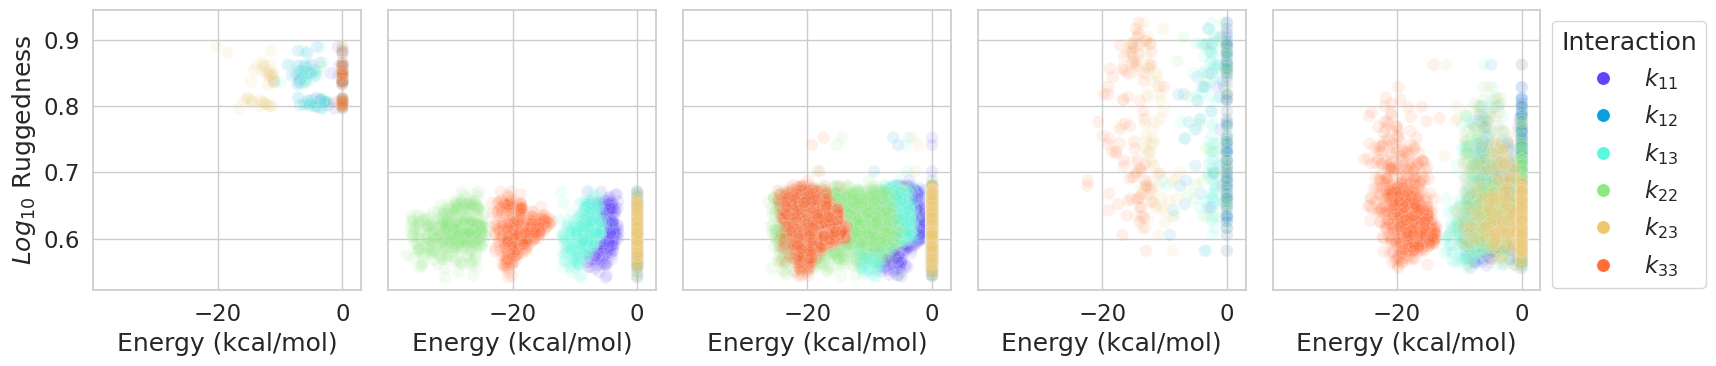

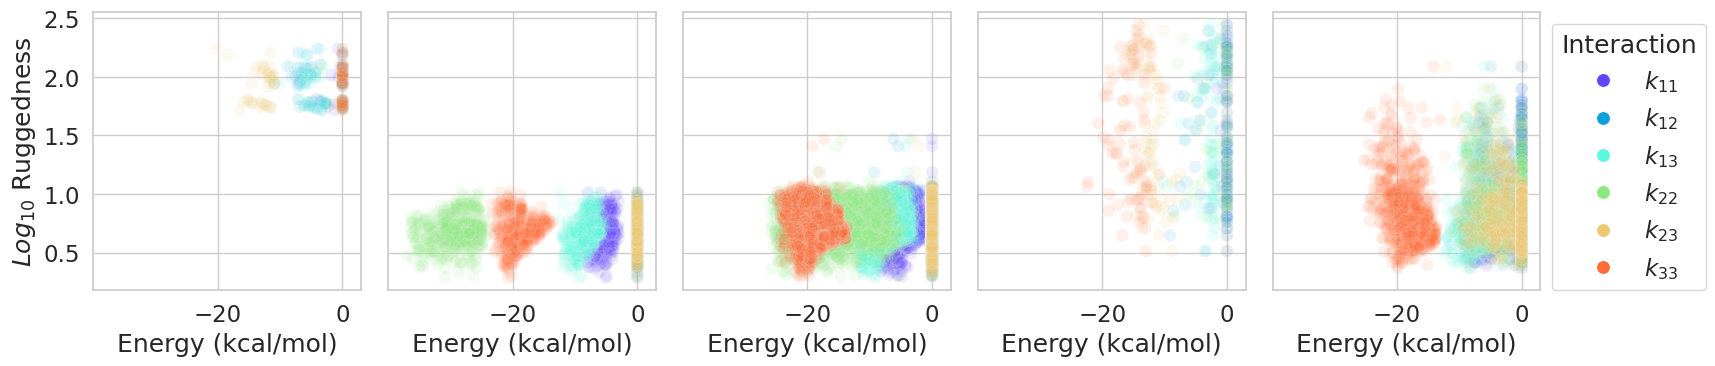

In [46]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.5)

dfm = df_plot[filt_c].melt(id_vars=['Cluster', 'Log ruggedness (adaptation)', 'Log ruggedness (adaptation) norm'],
                           value_vars=cols_e, value_name='Energy (kcal/mol)', var_name='Interaction name').sort_values('Interaction name')
dfm['Interaction'] = dfm['Interaction name'].apply(
    lambda x: dict(zip(cols_e, np.arange(len(cols_e))))[x])

# custom_palette2 = 'hls' # sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=len(cols_e))
custom_palette2 = sns.blend_palette(
    ["#6145fa", "#0ba0db", "#5af8de", "#8ce97f", '#ecc86f', '#ff6d38'], n_colors=len(cols_e))

for norm_setting in ['normalised', 'unnormalised']:

    y_col = 'Log ruggedness (adaptation)'
    if norm_setting == 'normalised':
        y_col = y_col + ' norm'

    for orientation in ['vertical', 'horizontal']:
        if orientation == 'horizontal':
            nrows = 1
            ncols = df_plot[filt_c]['Cluster'].nunique()
            xlabel = 'Energy (kcal/mol)'
            ylabel = r'$Log_{10}$ Ruggedness'
        else:
            nrows = df_plot[filt_c]['Cluster'].nunique()
            ncols = 1
            xlabel = r'$Log_{10}$ Ruggedness'
            ylabel = 'Energy (kcal/mol)'
        fig, axs = plt.subplots(nrows, ncols, figsize=(
            (3.5 + (2.5 if orientation == 'vertical' else 0))*ncols, 4*nrows), sharex=True, sharey=True)

        for ic, cluster in enumerate(sorted(df_plot[filt_c]['Cluster'].unique())):

            ax_scatter = axs.flat[ic]
            d = dfm[dfm['Cluster'] == cluster]
            is_legend = True if ic == (ncols - 1) else False
            g = sns.scatterplot(d,  # bins=None if len(d[y_col]) < 50 else 30, alpha=0.5,
                                x='Energy (kcal/mol)', y=y_col, hue='Interaction name',
                                alpha=0.1 if len(d) > 20 else 0.9, s=80,
                                ax=ax_scatter, palette=custom_palette2, legend=is_legend)
            ax_scatter.set_xlim(
                [dfm['Energy (kcal/mol)'].min() - 3, dfm['Energy (kcal/mol)'].max() + 3])
            ax_scatter.set_xlabel(xlabel)
            ax_scatter.set_ylabel(ylabel)
            # ax_scatter.set_title(f'Cluster {cluster}')
            ax_scatter.set_title('')

            if is_legend:
                for line in g.legend().get_lines():
                    line.set(alpha=1.0, markersize=10)
                sns.move_legend(g, "upper left", bbox_to_anchor=(
                    1, 1), title='Interaction')

        # plt.suptitle('Ruggedness in adaptable circuits\nby topological feature')
        plt.tight_layout()
        plt.savefig(os.path.join(
            top_write_dir, f'ruggedness_by_interaction_cluster_{orientation[:3]}{"_norm" if norm_setting == "normalised" else ""}.png'), dpi=300, transparent=True)

        if orientation == 'vertical':
            plt.close()

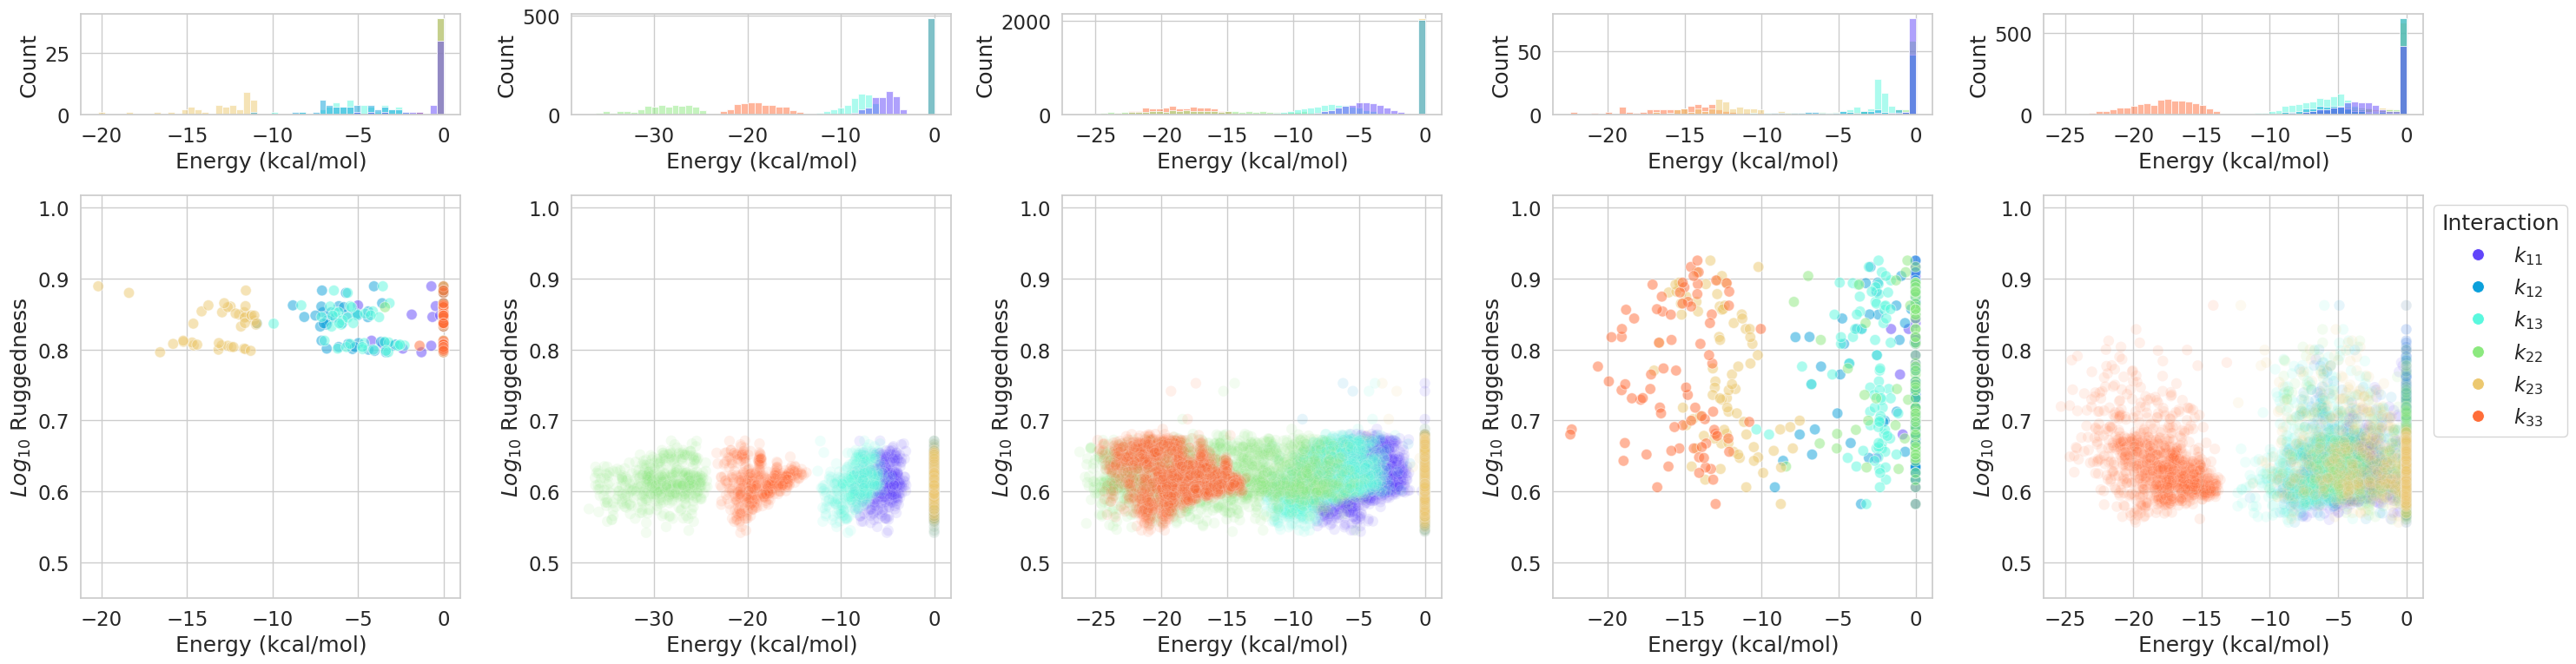

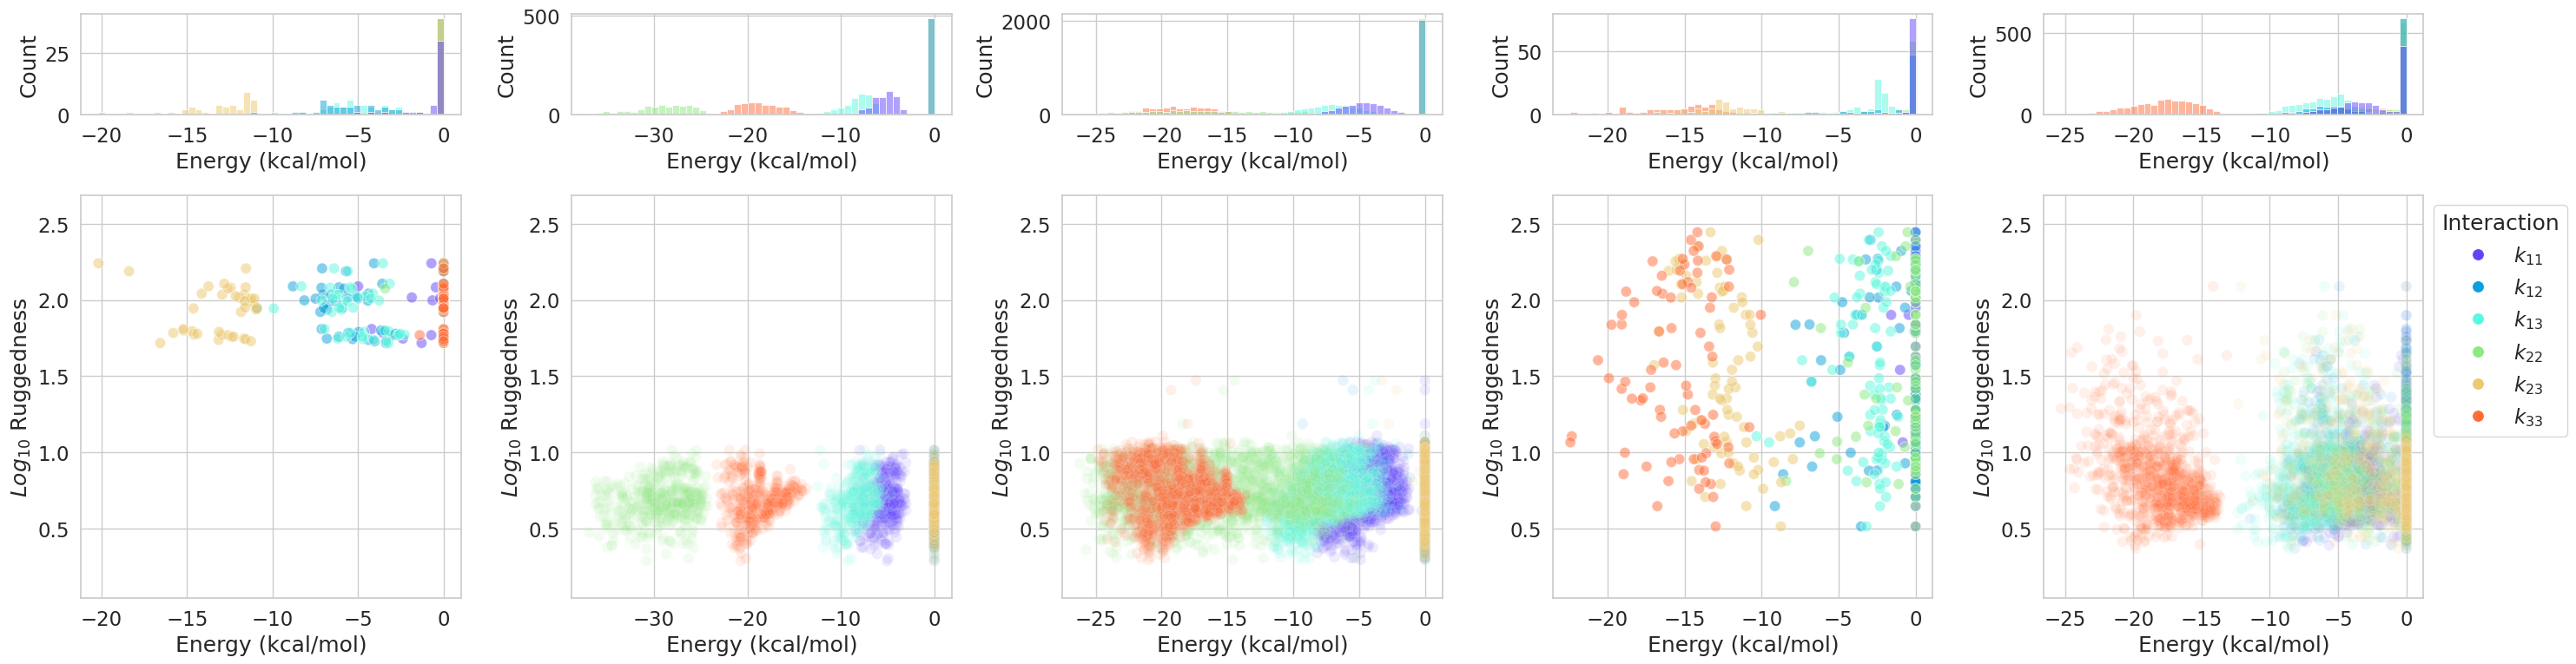

In [47]:
for norm_setting in ['normalised', 'unnormalised']:

    for orientation in ['vertical', 'horizontal']:

        x_col = 'Energy (kcal/mol)'
        y_col = 'Log ruggedness (adaptation)'
        if norm_setting == 'normalised':
            y_col = y_col + ' norm'
        if orientation == 'vertical':
            x_col, y_col = y_col, x_col

        nrows = 2
        ncols = df_plot[filt_c]['Cluster'].nunique()
        if orientation == 'vertical':
            nrows, ncols = ncols, nrows
        fig, axs = plt.subplots(nrows, ncols,
                                figsize=(
                                    6*ncols, 4*nrows),
                                gridspec_kw={
                                    'height_ratios': [1, 4] if orientation == 'horizontal' else [1] * nrows,
                                    'width_ratios': [4, 1] if orientation == 'vertical' else [1] * ncols
                                },
                                # sharex=True, sharey=True
                                )

        for ic, cluster in enumerate(sorted(df_plot[filt_c]['Cluster'].unique())):
            
            d = dfm[dfm['Cluster'] == cluster]

            is_legend = True if ((orientation == 'horizontal') and (ic == (ncols - 1))) or (
                (orientation == 'vertical') and (ic == 0)) else False
            is_legend_kde = False if orientation == 'horizontal' else True

            ax_kde = axs[0, ic] if orientation == 'horizontal' else axs[ic, 1]
            gk = sns.histplot(d, bins=50,
                             x=x_col if orientation == 'horizontal' else None,
                             y=y_col if orientation == 'vertical' else None,
                             hue='Interaction name',
                             ax=ax_kde, palette=custom_palette2, legend=(is_legend_kde and is_legend))

            ax_scatter = axs[1,
                             ic] if orientation == 'horizontal' else axs[ic, 0]
            gs = sns.scatterplot(d,  # bins=None if len(d[y_col]) < 50 else 30, alpha=0.5,
                                 x=x_col, y=y_col, hue='Interaction name',
                                 alpha=0.1 if len(d) > 2000 else 0.5, s=80,
                                 ax=ax_scatter, palette=custom_palette2, legend=(not (is_legend_kde) and is_legend))
            # xrange = dfm[x_col].max() - dfm[x_col].min()
            # ax_scatter.set_xlim(
            #     [dfm[x_col].min() - 0.2*xrange, dfm[x_col].max() + 0.2*xrange])
            ax_scatter.set_xlabel(r'$Log_{10}$ Ruggedness') if 'rugged' in x_col else ax_scatter.set_ylabel(r'$Log_{10}$ Ruggedness')
            ax_scatter.set_xlim([dfm[x_col].min() - 0.1*dfm[x_col].max(), dfm[x_col].max() + 0.1*dfm[x_col].max()]) if 'rugged' in x_col else ax_scatter.set_ylim(
                [dfm[y_col].min() - 0.1*dfm[y_col].max(), dfm[y_col].max() + 0.1*dfm[y_col].max()])
            # ax_scatter.set_ylabel(x_col)
            # ax_scatter.set_title(f'Cluster {cluster}')
            ax_scatter.set_title('')

            g = gk if is_legend_kde else gs
            if is_legend:
                if not(is_legend_kde):
                    for line in g.legend().get_lines():
                        line.set(alpha=1.0, markersize=10)
                sns.move_legend(g, "upper left", bbox_to_anchor=(
                    1, 1), title='Interaction')

        plt.tight_layout()
        plt.savefig(os.path.join(
            top_write_dir, f'ruggedness_wkde_by_interaction_cluster_{orientation[:3]}{"_norm" if norm_setting == "normalised" else ""}.png'), dpi=300, transparent=True)

        if orientation == 'vertical':
            plt.close()

# Crazy circle motif graphs


In [48]:
# fig, ax = plt.subplots(figsize=(12, 5))
# i_rlowest = df_plot[filt_c]['Log ruggedness (adaptation)'].idxmin()
# i_rhighest = df_plot[filt_c]['Log ruggedness (adaptation)'].idxmax()
# for i, idx in enumerate([i_rlowest, i_rhighest]):
#     w = df_plot[filt_c].iloc[idx][cols_e].values
#     # w = np.median(fake_circuits_cluster, axis=0)
#     create_network_inset(fig, ax,
#                          pos=pos[i],
#                          width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
#                                                                              vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
#                          node_color=colors[i], linewidth=2.5)
# ax.set_axis_off()

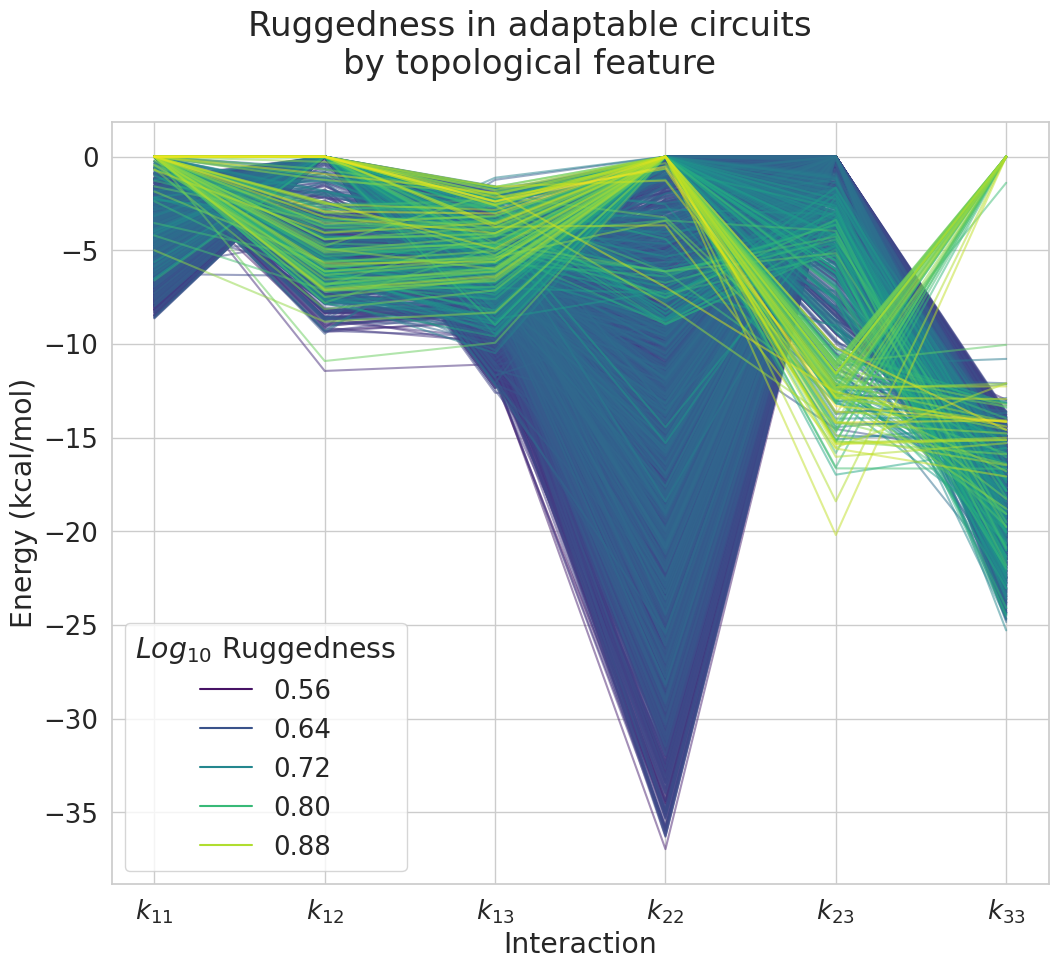

In [49]:
sns.set_context("notebook", font_scale=1.7)
dfm = df_plot[filt_c].melt(id_vars=['Cluster', 'Log ruggedness (adaptation)', 'Log ruggedness (adaptation) norm'],
                   value_vars=cols_e, value_name='Energy (kcal/mol)', var_name='Interaction name').sort_values('Interaction name')
dfm['Interaction'] = dfm['Interaction name'].apply(
    lambda x: dict(zip(cols_e, np.arange(len(cols_e))))[x])

plt.figure(figsize=(11, 10))
g = sns.lineplot(dfm.sort_values(by='Log ruggedness (adaptation) norm', ascending=False),
                 x='Interaction', y='Energy (kcal/mol)',
                 hue='Log ruggedness (adaptation) norm', alpha=0.5,
                 palette='viridis')
for line in g.legend().get_lines():
    line.set(alpha=1.0, markersize=15)
g.legend_.set_title(f'$Log_{{10}}$ Ruggedness')
plt.xticks(np.arange(len(cols_e)), cols_e)  # , rotation=45)
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.suptitle('Ruggedness in adaptable circuits\nby topological feature')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'ruggedness_by_interaction_energy.png'), dpi=300, transparent=True)

### Radar chart


In [50]:
def plot_radar_chart(df, i, ax, cols, labels, color='tab:blue', linewidth=2, alpha=0.05):
    # Step 1: Prepare data
    categories = labels
    values = (df[cols].iloc[i].round(1)).tolist()
    values += values[:1]  # repeat first value to close the circle

    # Step 2: Calculate angles for each axis
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Step 3: Create radar chart
    ax.plot(angles, values, color=color, linewidth=linewidth, alpha=alpha)
    # ax.fill(angles, values, color='tab:blue', alpha=0.25)

    # Step 4: Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([])  # hide radial ticks for cleaner look

    # Optional: Set range for radial axis
    # ax.set_ylim(0, 5)


# df_plot = df_plot.sort_values(by='Log ruggedness (adaptation)', ascending=True)
# colors = sns.color_palette("magma_r", n_colors=len(df_plot) ).as_hex()
# colors = np.array(colors)[np.argsort(df_plot['Log ruggedness (adaptation)'].values)]
# fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
# # df_plot[cols_e_norm] = df_plot[cols_e] / df_plot[cols_e].abs().max(axis=0)
# for i in range(len(df_plot)):
#     plot_radar_chart(df_plot, i, ax, cols_e, labels=cols_e, color=colors[i])

# plt.title("Adaptable circuit topologies by ruggedness", y=1.1)

# norm = plt.Normalize(vmin=df_plot['Log ruggedness (adaptation)'].min().min(), vmax=df_plot['Log ruggedness (adaptation)'].max().max())
# sm = plt.cm.ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
# cbar.set_label(f'$Log_{{10}}$ ruggedness', rotation=270, labelpad=25)

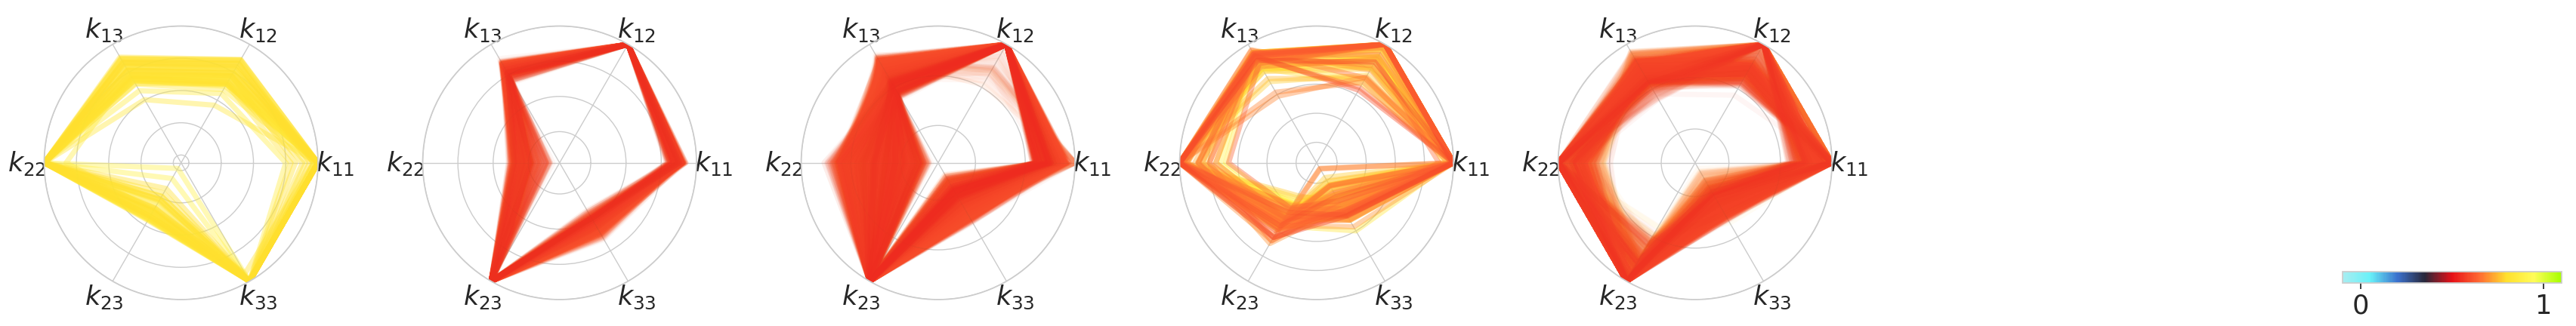

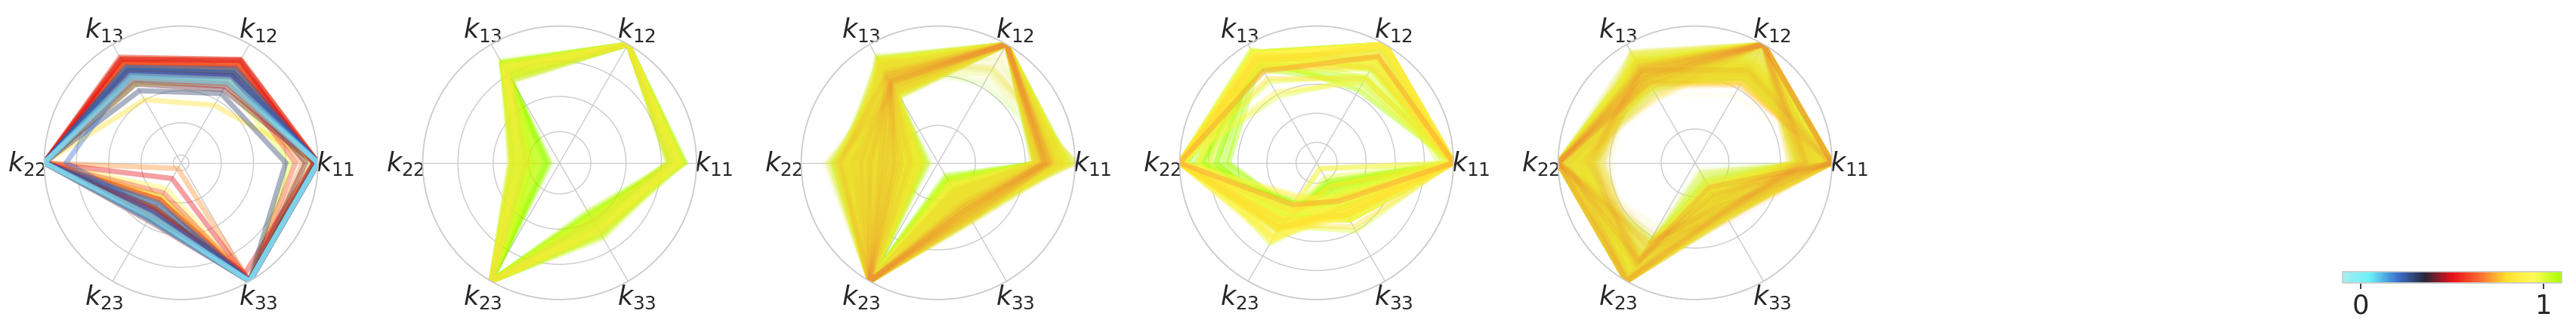

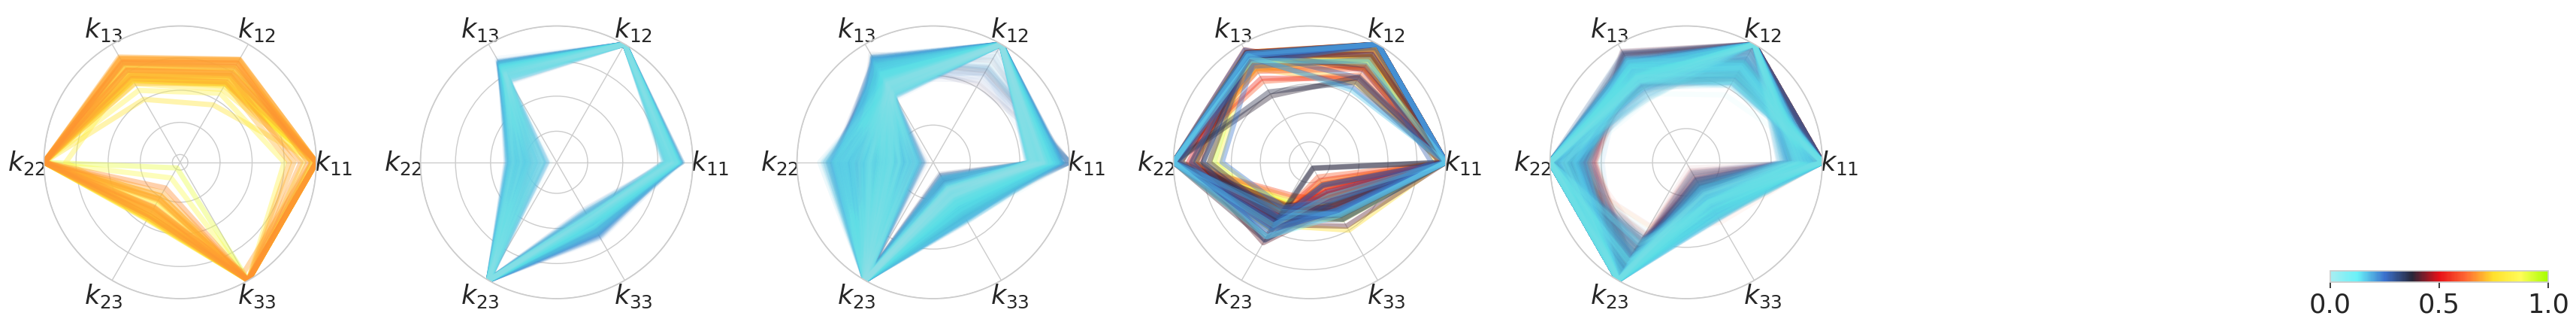

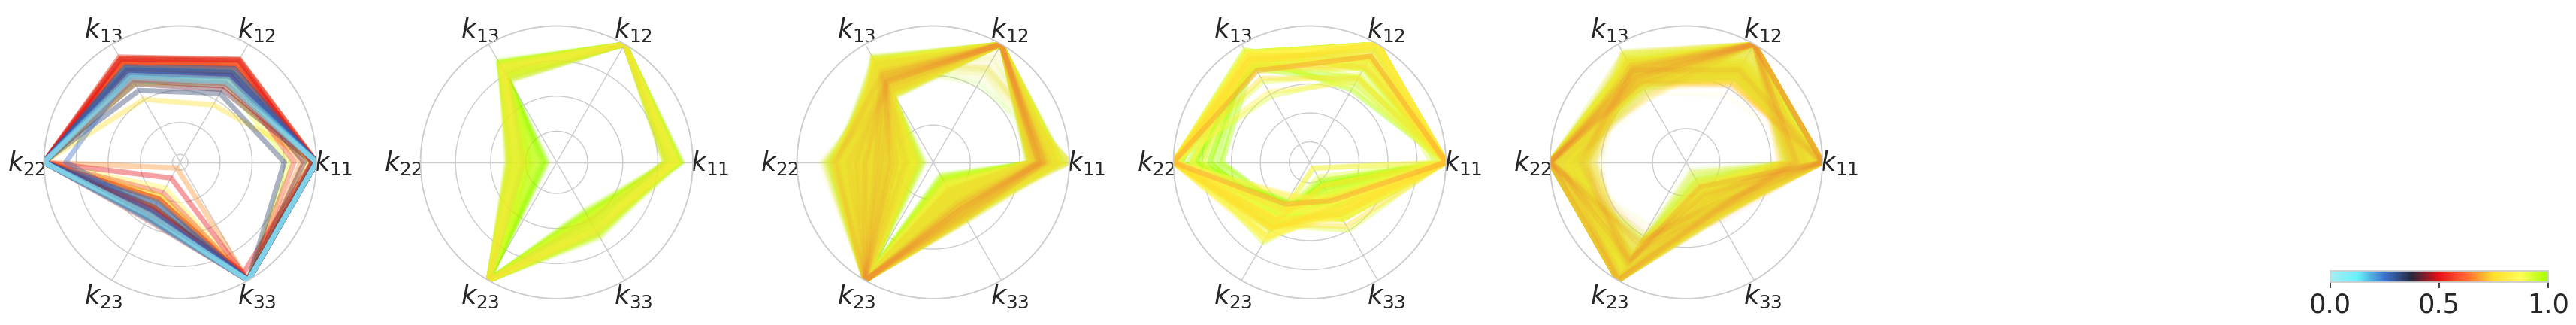

In [51]:
import matplotlib.colors as mcolors

sns.set_context("notebook", font_scale=2.3)

# for df_curr in [df_plot[filt_c], df_plot_lo, df_plot_hi]:
# df_plot[filt_c] = df_plot[filt_c].sort_values(by='Log ruggedness (adaptation)', ascending=False)
df_curr = df_plot[filt_c]  # .sort_index()

hues = ['Log ruggedness (adaptation) norm', 'Prompt Ruggedness']
# hues = ['Log ruggedness (adaptation)', 'Log ruggedness (adaptation) norm'] # 'Prompt Ruggedness'] #, 'Prompt Ruggedness Unnorm']
# hue = 'Log ruggedness (adaptation)'
# hue = 'Adaptation'
for k in hues:
    df_plot[k + ' scaled'] = np.interp(df_plot[k].values,
                                               (df_plot[k].min(), df_plot[k].max()), (0, 1))

vmin = df_plot[filt_c][hues].min().min()
vmax = df_plot[filt_c][hues].max().max()
clusters = np.unique(df_plot[filt_c]['Cluster'])

hues = hues + [k + ' scaled' for k in hues]

palette = 'icefire'  # 'magma_r'    "#dcff19",
custom_palette3 = sns.blend_palette(["#a8edf1", "#68f1f8", '#3b71cd', '#282739',
                                    "#e71017", "#ff6a33", "#ffe02e", "#fffc58", "#a6ff00"], as_cmap=True)
# cividis, crest, cubehelix_r, gist_earth, icefire, jet, managua, nipy_spectral, rainbow, prism, seismic
# cmap = sns.color_palette(custom_palette3, as_cmap=True)

for ih, hue in enumerate(hues):  # , 'Prompt Adaptation']):
    if 'scaled' in hue:
        # if 'Prompt' not in hue else all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].min()
        vmin = df_plot[filt_c][hue].min().min()
        vmax = df_plot[filt_c][hue].max().max()
    val_norm = (df_plot[filt_c].sort_index()[hue].values - vmin) / (vmax - vmin)
    colors_all = np.array(
        list(map(lambda val: mcolors.to_hex(custom_palette3(val)), val_norm)))

    # , (-np.inf, 0.7), (0.7, 1), (1, np.inf)]):
    for i_split, split in enumerate([(-np.inf, np.inf)]):

        df_curr = df_plot[filt_c].reset_index(drop=True)[df_plot[filt_c].reset_index(drop=True)
                                  [hue].between(*split, inclusive='both')]

        for orientation in ['horizontal', 'vertical']:
            if orientation == 'horizontal':
                ncol = len(clusters) + 2
                nrow = 1
            else:
                ncol = 1
                nrow = len(clusters) + 2
            fig, axs = plt.subplots(nrow, ncol, figsize=(
                5*ncol, 5*nrow), subplot_kw=dict(polar=True))
            plt.subplots_adjust(wspace=0.1, hspace=-0.7)
            for ic, cluster in enumerate(clusters):

                d = df_curr[df_curr['Cluster'] == cluster]
                if len(d) == 0:
                    axs[ic].set_axis_off()
                colors = np.array(colors_all)[d.index.to_numpy()]

                alpha = 0.05 if len(d) > 100 else (0.4 if len(d) > 20 else 0.9)
                for i in d.reset_index().sort_values(hue, ascending=False).index:
                    plot_radar_chart(
                        d, i, axs[ic], cols_e, labels=cols_e, color=colors[i], linewidth=5, alpha=alpha)

            norm = plt.Normalize(vmin=vmin, vmax=vmax)
            sm = plt.cm.ScalarMappable(cmap=custom_palette3, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[-1], orientation=orientation,
                                pad=0.1, shrink=0.8 if orientation == 'horizontal' else 0.6)
            # cbar.set_label(f'$Log_{{10}}$ ruggedness', rotation=270, labelpad=25)
            axs[-2].set_axis_off()
            axs[-1].set_axis_off()

            plt.tight_layout()
            plt.savefig(os.path.join(
                top_write_dir, f'radar_clusters_ruggedness_{orientation[:3]}{i_split}_{hue[:1]}{ih}.png'), dpi=300, transparent=True)

            if orientation == 'vertical':
                plt.close()

# Motifs for all circuits


<Axes: xlabel='adaptation', ylabel='Count'>

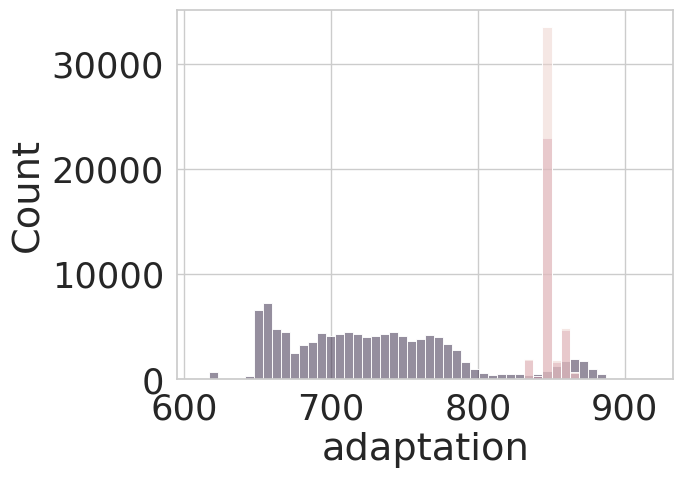

In [52]:
filt_r = (df_rugg['Log ruggedness (adaptation)'] >= -0.5) & (
    df_rugg['Log ruggedness (adaptation)'] <= 1.5)  # (rmin + (rmax - rmin) * 0.2)
rmin, rmax = np.nanmin(df_rugg[filt_r]['Log ruggedness (adaptation)']), np.nanmax(
    df_rugg[filt_r]['Log ruggedness (adaptation)'])
filt_r = filt_r & ((df_rugg['Log ruggedness (adaptation)'] >= (rmax - (rmax - rmin) * 0.2)) |
                   (df_rugg['Log ruggedness (adaptation)'] <= (rmin + (rmax - rmin) * 0.2)))
sns.histplot(df_rugg[filt_r],
             x='adaptation', hue='Log ruggedness (adaptation) bin', bins=50, legend=False)

In [53]:
# n_clusters = 30
# df_plot_r = plot_clusters(df_rugg[filt_r].index.to_numpy(
# ), df_rugg[filt_r], 'interaction_energy_clusters_rugg', n_clusters)

# Timeseries subplots of high vs. low ruggedness circuits


In [54]:
# fn_ys = os.path.join(dir_src_rugg, 'ys.npy')

# if os.path.exists(fn_ys):
#     ys = np.load(fn_ys)
#     ts = np.load(os.path.join(dir_src_rugg, 'ts.npy'))
# else:
#     # Stitch together ys from batches
#     ys = np.array([])
#     ts = np.array([])
#     idxs_adaptable = np.array(idxs_adaptable)

#     n_batches = len([i for i in os.listdir(dir_src_rugg) if 'batch' in i])
#     batch_sizes = []
#     for i in np.arange(n_batches):
#         dir_batch = f'batch_{i}'
#         if (not os.path.exists(os.path.join(dir_src_rugg, dir_batch))) or (
#                 len(os.listdir(os.path.join(dir_src_rugg, dir_batch))) == 0):
#             continue
#         ys_batch = np.load(os.path.join(dir_src_rugg, dir_batch, 'ys.npy'))
#         ts = np.load(os.path.join(dir_src_rugg, dir_batch, 'ts.npy'))

#         batch_size = len(ys_batch) // n_perturbs
#         idxs = idxs_adaptable[(idxs_adaptable >= int(np.sum(batch_sizes))) & (
#             idxs_adaptable < int(np.sum(batch_sizes)) + batch_size)]
#         idxs = idxs - int(np.sum(batch_sizes))
#         ys_batch = ys_batch.reshape(-1, n_perturbs,
#                                     ys_batch.shape[-2], ys_batch.shape[-1])
#         ys_batch = ys_batch[idxs]
#         if not len(ys):
#             ys = np.array(ys_batch)
#         else:
#             ys = np.concatenate([ys, ys_batch], axis=0)
#         batch_sizes.append(batch_size)

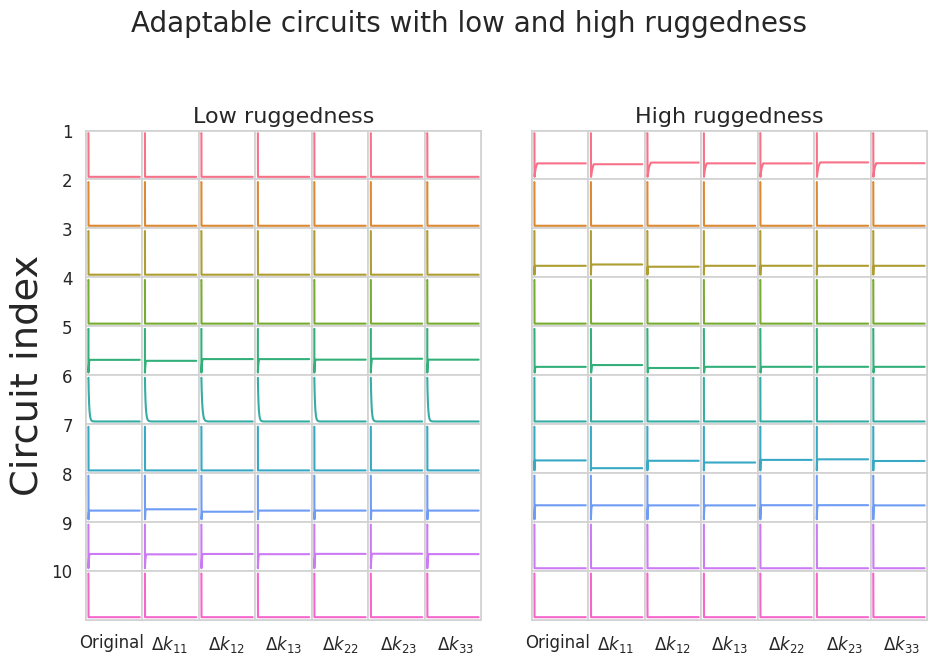

In [55]:
n_show_circs = 10
idxs_full_adapt_lorugg = df_plot.sort_values(
    by='Log ruggedness (adaptation)', ascending=True).index.to_list()[:n_show_circs]
idxs_full_adapt_hirugg = df_plot.sort_values(
    by='Log ruggedness (adaptation)', ascending=False).index.to_list()[:n_show_circs]

# Create a figure with two large subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

sns.set_style('white')

nrows = n_show_circs
ncols = n_perturbs
ys_out_r = ys_out.reshape(n_samples, n_perturbs, ys_out.shape[1])
for i, (ax, idxs, title) in enumerate(zip(axs, [idxs_full_adapt_lorugg, idxs_full_adapt_hirugg], ['Low ruggedness', 'High ruggedness'])):
    # Create a 5x5 grid of subplots within each large subplot
    # for ii, (row, col) in enumerate(itertools.product(range(n_show_circs), range(n_perturbs))):
    itmax = len(ts) // 4
    for row in range(nrows):
        ymin = 0 #np.nanmin(ys_out_r[idxs[row], :, :])
        ymax = 1 #np.nanmax(ys_out_r[idxs[row], :, :])
        yrange = ymax - ymin
        for col in range(ncols):
            inset_ax = ax.inset_axes(
                [col * 1/ncols, 1 - (row + 1) * 1/nrows, 1/ncols, 1/nrows])
            ys_p = ys_out_r[idxs[row], col, :itmax]
            ys_p = np.interp(ys_p, (np.nanmin(ys_p), np.nanmax(ys_p)), (ymin, ymax))
            inset_ax.plot(ts[:itmax], ys_p + row + col, color=sns.color_palette('husl', nrows)[row])
            inset_ax.set_xticks([])
            inset_ax.set_yticks([])
            ylim = (ymin - 0.06*yrange + row + col, ymax + 0.06*yrange + row + col)
            inset_ax.set_ylim(ylim)
            for spine in inset_ax.spines.values():
                spine.set_edgecolor('lightgrey')

    tick_labels = [''] * 5 + ['Original']
    for c in cols_e:
        tick_labels = tick_labels + [''] * 10 + [f'$\Delta$' + c]
    tick_labels = tick_labels + [''] * 5
    ax.set_xticks(np.arange(len(tick_labels)))
    ax.set_xticklabels(tick_labels, fontsize=12)
    ax.set_yticks([])
    if i == 0:
        ax.set_yticks(np.arange(nrows+1))
        ax.set_yticklabels(
            (list(np.arange(nrows) + 1) + [''])[::-1], fontsize=12)
        ax.set_ylabel('Circuit index')
    ax.set_title(title, fontsize=16)

# Adjust layout and show the figure
plt.suptitle('Adaptable circuits with low and high ruggedness', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'timeseries_stack.png'),
            dpi=300, bbox_inches='tight', transparent=True)

In [56]:
df_rugg['overshoot/initial'] = df_rugg['overshoot'] / \
    df_rugg['initial_steady_states']

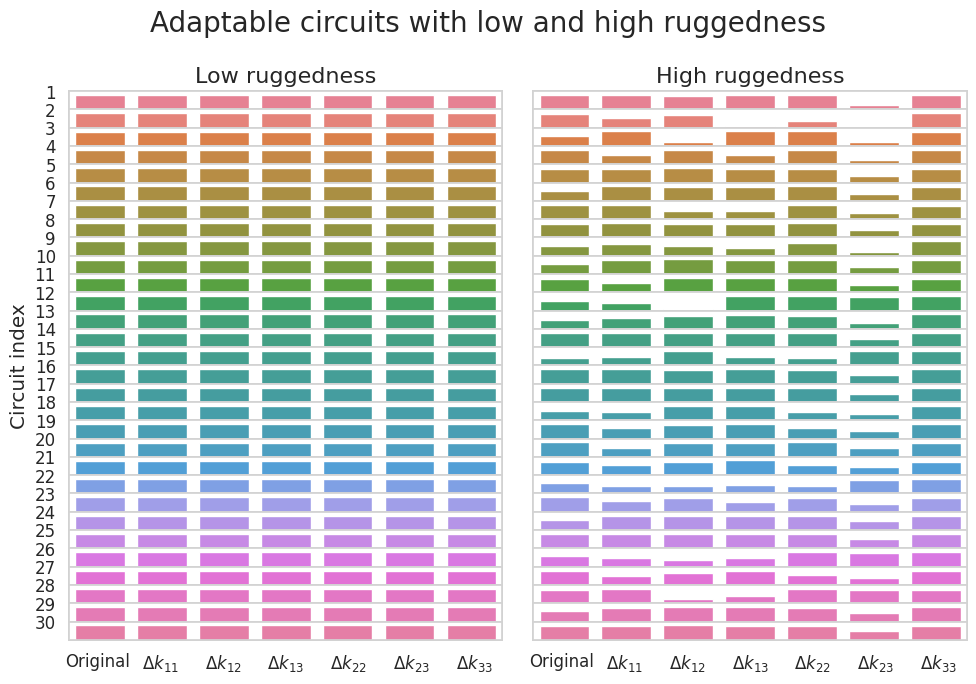

In [57]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.2)

n_show_circs = 30
idxs_lorugg = df_rugg[df_rugg['adaptation'] > 850].sort_values(
    by='Log ruggedness (adaptation)', ascending=True).index.to_list()[:n_show_circs]
idxs_hirugg = df_rugg[df_rugg['adaptation'] > 850].sort_values(
    by='Log ruggedness (adaptation)', ascending=False).index.to_list()[:n_show_circs]

fig, axs = plt.subplots(1, 2, figsize=(10, 7))
nrows = n_show_circs
ncols = n_perturbs
for i, (ax, idxs, title) in enumerate(zip(axs, [idxs_lorugg, idxs_hirugg], ['Low ruggedness', 'High ruggedness'])):

    for row in range(nrows):
        a = analytics_rugg['adaptation'].reshape(
            n_samples, n_perturbs, -1)[idxs[row], :, idxs_output]
        # sns.lineplot(a, color=sns.color_palette('husl', n_show_circs)[row], ax=ax)
        # sns.scatterplot(a, color=sns.color_palette('husl', n_show_circs)[row], ax=ax)

        inset_ax = ax.inset_axes([0, 1 - (row + 1) * 1/nrows, 1, 1/nrows])
        sns.barplot(a, color=sns.color_palette(
            'husl', n_show_circs)[row], ax=inset_ax)
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        for spine in inset_ax.spines.values():
            spine.set_edgecolor('lightgrey')

        inset_ax.set_ylim(700, inset_ax.get_ylim()[1])

    tick_labels = [''] * 5 + ['Original']
    for c in cols_e:
        tick_labels = tick_labels + [''] * 10 + [f'$\Delta$' + c]
    tick_labels = tick_labels + [''] * 5
    ax.set_xticks(np.arange(len(tick_labels)))
    ax.set_xticklabels(tick_labels, fontsize=12)
    ax.set_yticks([])
    if i == 0:
        ax.set_yticks(np.arange(nrows+1))
        ax.set_yticklabels(
            (list(np.arange(nrows) + 1) + [''])[::-1], fontsize=12)
        ax.set_ylabel('Circuit index')
    ax.set_title(title, fontsize=16)

# Adjust layout and show the figure
plt.suptitle('Adaptable circuits with low and high ruggedness', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'timeseries_stack_bars.png'),
            dpi=300, bbox_inches='tight', transparent=True)

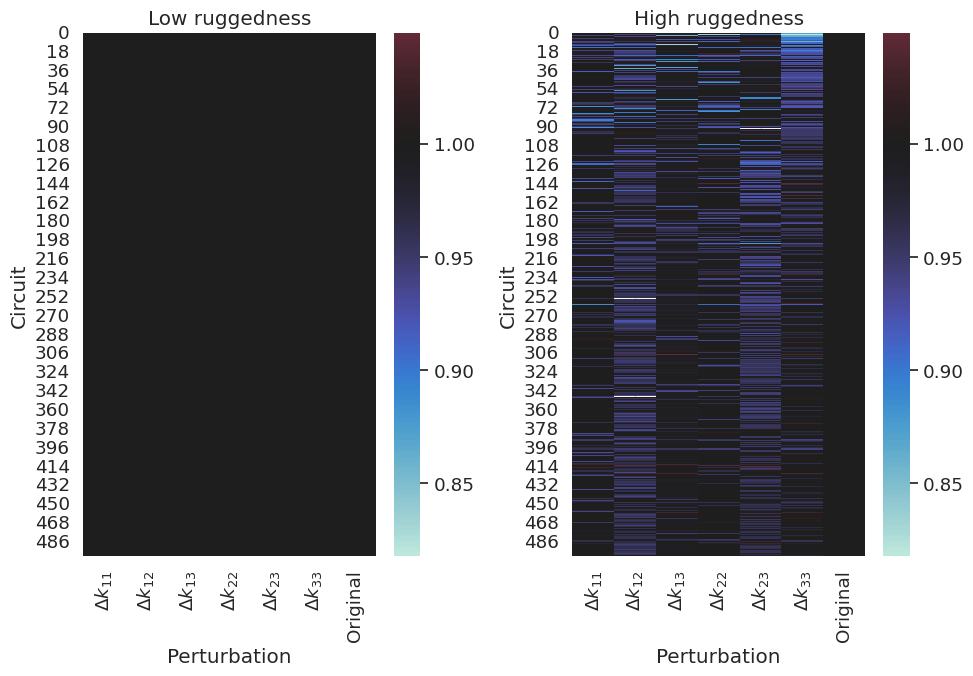

In [58]:
n_show_circs = 500
idxs_lorugg = df_rugg[df_rugg['adaptation'] > 850].sort_values(
    by='Log ruggedness (adaptation)', ascending=True).index.to_list()[:n_show_circs]
idxs_hirugg = df_rugg[df_rugg['adaptation'] > 850].sort_values(
    by='Log ruggedness (adaptation)', ascending=False).index.to_list()[:n_show_circs]

nrows = n_show_circs
ncols = n_perturbs

df_plot_rugg = pd.DataFrame()
df_plot_rugg['Perturbation'] = np.repeat(np.arange(n_perturbs)[None, :], repeats=len(idxs_lorugg)*2, axis=0).flatten()
tick_labels = [f'$\Delta$' + c for c in cols_e] + ['Original'] if config_rugg['resimulate_analytics'] else []
df_plot_rugg['Perturbation'] = df_plot_rugg['Perturbation'].apply(lambda x: dict(
    zip(np.arange(n_perturbs), tick_labels))[x]
)
df_plot_rugg['Circuit'] = np.concatenate([np.repeat(np.arange(len(idxs_lorugg)), repeats=n_perturbs).flatten() for i in range(2)])
df_plot_rugg['Adaptation'] = np.concatenate([(analytics_rugg['adaptation'].reshape(
            n_samples, n_perturbs, -1)[idxs_hilo, :, idxs_output] / (
                analytics_rugg['adaptation'].reshape(
            n_samples, n_perturbs, -1)[idxs_hilo, idx_perturb_og, idxs_output][..., None]
            )).flatten() for idxs_hilo in [idxs_lorugg, idxs_hirugg]], axis=0)
df_plot_rugg['level'] = 'Low ruggedness'
df_plot_rugg.loc[len(idxs_hirugg)*n_perturbs:, 'level'] = 'High ruggedness'
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
for i, l in enumerate(df_plot_rugg['level'].unique()):
    heatmap_data = df_plot_rugg[df_plot_rugg['level'] == l].pivot_table(
        index='Circuit',
        columns='Perturbation',
        values='Adaptation'
    )
    sns.heatmap(heatmap_data, ax=axs[i],
                center=1,
                vmin=df_plot_rugg['Adaptation'].min(),
                vmax=df_plot_rugg['Adaptation'].max(),
                )
    axs[i].set_title(l)
    
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'adaptation_heatmap.png'),
            dpi=300, bbox_inches='tight', transparent=True)